# Data Cleaning and Munging

## Combining files

We have a total of 20 files broken down into 4 schools (`access_code`) and each of them have 5 groups of variables (`game_code`). Below is the list of `game_code` and variables we are interested in:

**1)** 3008: spawned position

**2)** 4002: foodShot, foodNeeded

**3)** 4003: alienTypeAndColor, hitType, speed

**4)** 4004: reactionTime, eyeReactionTime

**5)** 4005: hit position

In order to combine all of them into one we need to do the following:

###   1)  Combine different `access_code` files within `game_code`

For each `game_code` we have to stack the five files (different `access_code`) vertically (all column names must match)
            

###   2) Combine different  `game_code`  files

The number of rows across different `access_code` doesn't need to match because each `access_code` contains a different number of participants. However, to merge different `game_code` files side-by-side we expected the same number of rows from step (1). To perform the merge we tried to use some of the common keys (`"userID", "sesID", "gameLevel", "alienID"`) among different `game_code`  files. And found that `sesID` is not a unique id per game level played. It is created when the user launches the game platform while a `gsUserID` is created when the user further opens the game (game platform has multiple games)

### Assign `gameID`

There is not a list of keys we can depend on, so we spend a lot of time trying to figure out how to accurately merge the files. First of all the `logTimestamp` and `gameTime` were not consistent (more on that later). So we decided to create a unique id for every game level played by a user. A user may not complete the game level so to avoid further issues with merging we filtered those out by first assigning a new gameID everytime alienID is 1 then we matched those games with the expected number of alienID to filter out the rows if that game was not completed (`filter_incomplete_game()`).

Note: This `gameID` cannot be used as a key to merge across different `game_code` because we have different numbers of rows in each `game_code` file and the order in which the `gameID` might not be consistent. This will only be used to get rid of rows that are incomplete `gameLevel`.


### Issue with merging `game_code`  files

We found a mismatched number of rows, which was an issue when merging the files into one side-by-side. There was no unique id every time a game was played, so we spent a lot of time trying to find out why the rows didn't match.  

4003, 4004 and 4005 have the same number of rows (243k), but the other two are different (3002: 244k, 4002: 305k). Even the three access codes with the same number of rows didn't produce a complete match when joined. All of this was a surprise to us because we thought originally the full data is split into multiple tables for storing purposes. So, we looked deeper into the data to find out where the problem was and found that rows of `game_code` are independently created, which also explained why the `logTimestamp` was not consistent across `game_code`. `logTimestamp`is the timestamp of when the server received the file not not when the game was played. Moreover, there were cases where two records of an alienID were logged at two different times and they were not in the correct order of `logTimestamp`.

 **Issue (1)** This issue affected all `game_code` files.
 
Because of inconsistency in the order of alien_id and timestamp we couldn't solely depend on `logTimestamp` . To solve this issue we keep the row with the first timestamp if every column except for the `logTimestamp` is the same.

    df_3008 = pd.read_csv(os.path.join(my_path, 'ATM1F18_ayce_3008.csv'))

    filter_df = df_3008[(df_3008['accessCode'] == 'ATM1F18')
            & (df_3008['userID']== 16948 )  
            & (df_3008['sesID']== 'df192h3fubauhvdmj99qsnf5g7')
           & (df_3008['gameLevel']== 'SpaceCakesLevel 3-1-0')]
    filter_df.sort_values(["userID","logTimestamp","alienID"]).reset_index(drop =True)


**Can we use `gameTime` instead?**

It is not the timestamp of when the data was generated, rather the time that passed between when the game was opened/started in milliseconds.   

    from datetime import datetime
    timestamp = datetime.fromtimestamp(650313)
    print(timestamp.strftime('%Y-%m-%d %H:%M:%S'))

Yes, we can use `gameTime` instead of logTimestamp to sort the data.

    filter_df.sort_values(["userID","gameTime","alienID"]).reset_index(drop =True)

Since `gameTime` is more consistent than `logTimestamp`, we will create new `logTimestamp` (`new_logTimestamp`) that starts with the  `logTimestamp` for the first `alienID` then calculates the other `logTimestamp` by taking the difference between two `gameTime`. But since the `logTimestamp` varies and we need to merge the files we will just do this at the end after merging the files


**2 a) Issue with 4003, 4004 and 4005**

Initially, we thought ['userID', 'sesID', 'gameLevel', 'alienID'] was unique and could be used to combine those five `game_code`, but turns out the `sesID` is just an ID assigned every time a user logs into the app. Therefore, there were multiple gamelevels and even the same level game was played multiple times within a `sesID`. A slightly better id was `gsUserID`, which was an id assigned every time a user logs into the game (the app has multiple games). If a user plays the same or new level the `gsUserid` doesn't change. But, using `gsUserID` greatly reduced the unique ID problem. We decided to rename `gsUserID` if it is duplicated when grouped by "userID", "gameLevel" and "alienID", by sorting the data based on the `logTimestamp`.

**2 b) Issue with 3008**
It made sense that 3008 had more rows than the other groups because 3008 records the spawned positions of the aliens. Maybe the aliens spawned and were recorded in the database but the player never finished playing so other variables were not recorded.

**2 c) Issue with 4002**
4002 had more rows than the rest because for complicated levels some aliens need both Food/Drink and we did not find any "foodShot" with "Food/Drink". The issue was that a row was created per button pressed so, when "foodNeeded" was "Food/Drink" we needed to combine two rows. Unfortunately the second row was not marked as "Food/Drink" so we have to depend on `logTimestamp` to merge those rows.




###   1)  Combine different `access_code` files within `game_code`

- collect all files with the same `game_code` by parsing out the last string after "_" in the filename
- column names for all files within a `game_code` should be same
- stack them on top of each other
- remove irrelevant columns
- convert columns to correct data type, for e.g. `logTimestamp` is stored as string and should be datetime
- remove irrelevant strings from column values, for e.g. `gameLevel` has value starting with "SpaceCakesLevel " which prevents the dataframe to sort
- In 3008 rename columns "posX" and "posY" to "spawnPosX" and "spawnPosY"
- In 4005 rename columns "posX" and "posY" to "hitPosX" and "hitPosY"
- `gameTime` is in milliseconds and we don't need that level of granularity, so we converted them into seconds. This also allows us to combine files side by side discussed later in step (2)


In [1]:
import pandas as pd
import numpy as np
import glob
import os
#replace the followig `my_path` with the path where the files are located in your computer
my_path = '/Users/domaghale/Desktop/Fall 2021/Programming in DS/FinalProject/Selected Files'
def list_file_and_codes(path):
    #list all of the filenames 
    os.chdir(path)
    file_names = os.listdir(path) 
    csv_files = [f for f in file_names if ".csv" in f]
    #list all the file names including the file path in a list 
    full_paths = []
    # using split function list the school codes as `access_code`
    access_code = []
    # using split function list the variable code codes as `game_code`
    game_code = []
    for f in csv_files:
        full_path = os.path.join(path, f)
        full_paths.append(full_path)
        access_code.append(f.split('_')[0])
        game_code.append(f.split('_')[-1].split('.')[0])
    return csv_files, full_paths, access_code, game_code

file_names, full_paths, access_code, game_code = list_file_and_codes(my_path)

#five examples each
print("files:\n", file_names[:],"\n")
print("school code:\n", access_code[0:5],"\n")
print("variable code:\n", game_code[0:5])


files:
 ['ATM1F18_ayce_4005.csv', 'ATM1F18_ayce_4004.csv', 'ATM1F18_ayce_3008.csv', 'ATM1F18_ayce_4003.csv', 'ATM1F18_ayce_4002.csv', 'ATHF18_ayce_4005.csv', 'ATMBF18_ayce_4003.csv', 'ATMBF18_ayce_4002.csv', 'ATHBF18_ayce_3008.csv', 'ATHF18_ayce_4004.csv', 'ATHBF18_ayce_4003.csv', 'ATMBF18_ayce_3008.csv', 'ATHBF18_ayce_4002.csv', 'ATHF18_ayce_4003.csv', 'ATMBF18_ayce_4005.csv', 'ATMBF18_ayce_4004.csv', 'ATHF18_ayce_4002.csv', 'ATHBF18_ayce_4005.csv', 'ATHF18_ayce_3008.csv', 'ATHBF18_ayce_4004.csv'] 

school code:
 ['ATM1F18', 'ATM1F18', 'ATM1F18', 'ATM1F18', 'ATM1F18'] 

variable code:
 ['4005', '4004', '3008', '4003', '4002']


In [2]:
def grp_files_param(file_list, code_type):
    """
    param file_list: must be the list that contains all of the file names 
    param code_type: must be the list that needs to reference as groups for files in file_list
    return: list where each index contains all the files within a group of param 
    """
    grp_files = []
    unique_param = list(np.unique(code_type))
    for i in range(len(unique_param)):
        indices = [index for index, element in enumerate(code_type) if element == unique_param[i]]
        grp_files.append([file_list[i] for i in indices])
    return grp_files

def drop_columns(df):
    """
    param: columns tha
    """
    d_cols = ['participantID','logID','jotID','gameKey']
    new_df = df.copy()
    new_df= new_df.drop(columns=new_df.columns[new_df.columns.isin(d_cols)].values)
    return new_df

def convert_gameTime(df):
    new_df = df.copy()
    new_df["gameTime"] = round(new_df["gameTime"]/1000, 0)
    return new_df

def replace_gameLevel(df):
    """
    param:dataframe that contains column `gameLevel` 
    return: dataframe that gets rid of "SpaceCakesLevel " from column `gameLevel` because that string 
    prevents sorting to work as expected 
    """
    df_c = df.copy()
    df_c['gameLevel'] = df_c['gameLevel'].str.replace("SpaceCakesLevel ","")
    return df_c

def concat_files_param(path, file_list, code_type):
    """
    path: path of where the files are located
    file_list: must be the list that contains all of the file names 
    param code_type: must be the list that needs to reference as groups for files in file_list
    return: dictionary with all of the data combined for each value in param
    """
    # cannot concatenate based on full file path so need to change directory
    os.chdir(path)
    df_dict = {}
    grp_files = grp_files_param(file_list, code_type)
    unique_param = list(np.unique(code_type))
    for code in range(len(unique_param)):
        #df_dict[code] = pd.DataFrame(pd.concat(map(pd.read_csv, grp_files[code])))
        df = pd.DataFrame(pd.concat(map(pd.read_csv, grp_files[code])))
        df['logTimestamp'] = pd.to_datetime(df['logTimestamp'])
        df_dict[code] = convert_gameTime(replace_gameLevel(drop_columns(df.sort_values(["userID","gsUserID","gameTime","gameLevel","alienID"]).reset_index(drop =True))))
        print("param", unique_param[code], "has shape", df_dict[code].shape)
        #rename "posX" and "posY"
        if unique_param[code] == "4005":
            df_dict[code] = df_dict[code].rename(columns={"posX": "hitPosX", "posY":"hitPosY"})
        elif unique_param[code] == "3008":
            df_dict[code] = df_dict[code].rename(columns={"posX": "spawnPosX", "posY":"spawnPosY"})
    return df_dict

# there are 4 school_code each of which contain a variable code
# stack the files based of the variable code (`game_code`)
grp_game_code_dict = concat_files_param(my_path, file_names, game_code)

#grp_game_code_dict contains 5 dataframes each contains files with common game code stacked
#view dataframe with first game_code 
#grp_game_code_dict[0]

param 3008 has shape (244006, 11)
param 4002 has shape (305325, 11)
param 4003 has shape (243580, 12)
param 4004 has shape (243580, 12)
param 4005 has shape (243580, 12)


In [3]:
# we need to parse out game level and nth attempt from `gamelevel`
def reassign_gameLevel(df):
    df_c = df.copy()
    df_c[['x','y','attempt']] = df_c.gameLevel.str.split('-', expand=True)
    df_c[['x','y','attempt']] = df_c[['x','y','attempt']].apply(pd.to_numeric, errors='coerce')
    df_c['new_gameLevel'] = (5* df_c['x'])+df_c['y']+1
    df_c['attempt']=df_c['attempt']+1
    df_c = df_c.drop(columns=["x", "y"])
    return df_c

for g in range(len(grp_game_code_dict)):
    grp_game_code_dict[g]=reassign_gameLevel(grp_game_code_dict[g])

In [4]:
#example
test_gameLevel = grp_game_code_dict[0].copy()
print("check if correct", 5*2+2+1)
test_gameLevel[test_gameLevel['gameLevel'] == '2-2-6'][["gameLevel", "attempt", "new_gameLevel"]].head(2)

check if correct 13


,gameLevel,attempt,new_gameLevel
227832,2-2-6,7,13
227833,2-2-6,7,13


In [5]:
def split_alienTypeAndColor(df):
    df_c = df.copy()
    if "alienTypeAndColor" in df_c:
        df_c['alienTypeAndColor'] = df_c['alienTypeAndColor'].str.replace('Eyed', 'Eyed,')
        df_c[['alienType','alienColor']] = df_c.alienTypeAndColor.str.split(',', expand=True)
    return df_c

for g in range(len(grp_game_code_dict)):
    if "alienTypeAndColor" in grp_game_code_dict[g]:
        print(grp_game_code_dict[g]["gameCode"].unique())
        grp_game_code_dict[g] = split_alienTypeAndColor(grp_game_code_dict[g])

grp_game_code_dict[2].head()

[4003]


,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,alienTypeAndColor,hitType,speed,attempt,new_gameLevel,alienType,alienColor
0,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4003,2018-10-15 19:41:53,0-0-0,25.0,1,"TwoEyed,Red",WRONG,100,1,1,TwoEyed,Red
1,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4003,2018-10-15 19:41:54,0-0-0,26.0,2,"TwoEyed,Red",HIT,100,1,1,TwoEyed,Red
2,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4003,2018-10-15 19:41:56,0-0-0,28.0,3,"TwoEyed,Blue",WRONG,100,1,1,TwoEyed,Blue
3,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,4003,2018-10-17 11:37:16,0-0-0,26.0,1,"TwoEyed,Red",HIT,100,1,1,TwoEyed,Red
4,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,4003,2018-10-17 11:37:24,0-0-0,34.0,2,"OneEyed,Blue",MISSED,100,1,1,OneEyed,Blue


In [6]:
#drop that are duplicates (same across all column values) 
for g in range(len(grp_game_code_dict)):
    #print(grp_game_code_dict[f])
    print("gameCode :", grp_game_code_dict[g]['gameCode'].unique())
    if grp_game_code_dict[g].duplicated().any() == False:
        print("Any duplicates :",grp_game_code_dict[g].duplicated().any())
        print("number of rows", len(grp_game_code_dict[g]))
    else:
        print("Any duplicates :",grp_game_code_dict[g].duplicated().any())
        print("number of rows before duplicates dropped", len(grp_game_code_dict[g]))
        grp_game_code_dict[g] = grp_game_code_dict[g].drop_duplicates()
        print("number of rows before duplicates dropped", len(grp_game_code_dict[g]))
    print("-"*20)
        

gameCode : [3008]
Any duplicates : False
number of rows 244006
--------------------
gameCode : [4002]
Any duplicates : True
number of rows before duplicates dropped 305325
number of rows before duplicates dropped 305324
--------------------
gameCode : [4003]
Any duplicates : False
number of rows 243580
--------------------
gameCode : [4004]
Any duplicates : False
number of rows 243580
--------------------
gameCode : [4005]
Any duplicates : False
number of rows 243580
--------------------


# Challenge 2

### Missing rows in one file but not others

We need to remove the test user, but because it has fewer records we decided to use it to compare the different `gameCode` and found one of the major inconsistencies in the records across different files.  

Below is the list of game_code and variables we are interested in:

1) 3008: spawned position

2) 4002: foodShot, foodNeeded

3) 4003: alienTypeAndColor, hitType, speed

4) 4004: reactionTime, eyeReactionTime

5) 4005: hit position

For the test user `gameCode` 3008 has 73 rows, 4002 has 12 rows, and 4003, 4004 and 4005 has 71 records.

It makes sense that 3008 contains more records than others because maybe the alien spawned but the user didn't play/hit the buttons so other `gameCode` were not recorded. However, it does not make sense why 4002 has fewer records than the others. Similarly, we found that the total number of game levels for 4002 was fewer than others.

Note: For other users we found that 4002 should have more rows because if aliens need "FOOD/DRINK" (hit both buttons at the same time) then two rows are created.



In [7]:
for i in range(5):
    test_user = grp_game_code_dict[i].copy() 
    test_user=test_user[test_user.userID == 115]
    print("number of rows for test user:",test_user['gameCode'].unique(),len(test_user))

number of rows for test user: [3008] 73
number of rows for test user: [4002] 12
number of rows for test user: [4003] 71
number of rows for test user: [4004] 71
number of rows for test user: [4005] 71


In [8]:
test_user1 = grp_game_code_dict[1].sort_values(["userID","gsUserID","gameTime","gameLevel","alienID"])
test_user1=test_user1[test_user1.userID == 115]
test_user1.head(5)

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,foodShot,foodNeeded,attempt,new_gameLevel
0,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4002,2018-10-15 19:41:53,0-0-0,25.0,1,FOOD,DRINK,1,1
1,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4002,2018-10-15 19:41:54,0-0-0,26.0,2,DRINK,DRINK,1,1
2,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4002,2018-10-15 19:41:56,0-0-0,28.0,3,DRINK,FOOD,1,1
3,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,4002,2018-10-17 11:37:15,0-0-0,25.0,1,DRINK,DRINK,1,1
4,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,ea19bb67_c1bba31e3b72,4002,2018-10-15 19:42:47,0-0-0,15.0,1,DRINK,FOOD,1,1


In [9]:
test_user4 = grp_game_code_dict[4].sort_values(["userID","gsUserID","gameTime","gameLevel","alienID"])
test_user4=test_user4[test_user4.userID == 115]
print(len(test_user4))
test_user4.head(5)

71


,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,hitPosX,hitPosY,oldReactionTime,attempt,new_gameLevel
0,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4005,2018-10-15 19:41:53,0-0-0,25.0,1,267,704,0.0,1,1
1,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4005,2018-10-15 19:41:54,0-0-0,26.0,2,483,760,0.0,1,1
2,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4005,2018-10-15 19:41:56,0-0-0,28.0,3,314,764,0.0,1,1
3,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,4005,2018-10-17 11:37:16,0-0-0,26.0,1,855,698,0.0,1,1
4,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,4005,2018-10-17 11:37:24,0-0-0,34.0,2,535,82,0.0,1,1


In [10]:
test_user14 = pd.merge(test_user1, test_user4, on=['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel',
                                                   'alienID'], 
                     how="outer", 
                     indicator=True)   
test_user14[test_user14["_merge"] == "both"].head(5)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,foodShot,...,new_gameLevel_x,gameCode_y,logTimestamp_y,gameTime_y,hitPosX,hitPosY,oldReactionTime,attempt_y,new_gameLevel_y,_merge
0,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4002.0,2018-10-15 19:41:53,0-0-0,25.0,1,FOOD,...,1.0,4005,2018-10-15 19:41:53,25.0,267,704,0.0,1,1,both
1,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4002.0,2018-10-15 19:41:54,0-0-0,26.0,2,DRINK,...,1.0,4005,2018-10-15 19:41:54,26.0,483,760,0.0,1,1,both
2,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,70dc268b_e6f47f9d7d57,4002.0,2018-10-15 19:41:56,0-0-0,28.0,3,DRINK,...,1.0,4005,2018-10-15 19:41:56,28.0,314,764,0.0,1,1,both
3,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,4002.0,2018-10-17 11:37:15,0-0-0,25.0,1,DRINK,...,1.0,4005,2018-10-17 11:37:16,26.0,855,698,0.0,1,1,both
4,ATM1F18,115,nkd79v3cpkptgrnh19miqetn76,ea19bb67_c1bba31e3b72,4002.0,2018-10-15 19:42:47,0-0-0,15.0,1,DRINK,...,1.0,4005,2018-10-15 19:42:48,15.0,789,700,0.0,1,1,both


In [11]:
test_user14[test_user14["_merge"] == "left_only"].head(5)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,foodShot,...,new_gameLevel_x,gameCode_y,logTimestamp_y,gameTime_y,hitPosX,hitPosY,oldReactionTime,attempt_y,new_gameLevel_y,_merge


In [12]:
test_user14[test_user14["_merge"] == "right_only"].head(5)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,foodShot,...,new_gameLevel_x,gameCode_y,logTimestamp_y,gameTime_y,hitPosX,hitPosY,oldReactionTime,attempt_y,new_gameLevel_y,_merge
12,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,2,NaN,...,NaN,4005,2018-10-17 11:37:24,34.0,535,82,0.0,1,1,right_only
13,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,3,NaN,...,NaN,4005,2018-10-17 11:37:26,36.0,229,82,0.0,1,1,right_only
14,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,4,NaN,...,NaN,4005,2018-10-17 11:37:28,38.0,210,82,0.0,1,1,right_only
15,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,5,NaN,...,NaN,4005,2018-10-17 11:37:30,40.0,460,82,0.0,1,1,right_only
16,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,6,NaN,...,NaN,4005,2018-10-17 11:37:32,42.0,656,82,0.0,1,1,right_only


In [13]:
test_user14[test_user14["gsUserID"] == "c2603fd4_1121ef4b129b"]

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,foodShot,...,new_gameLevel_x,gameCode_y,logTimestamp_y,gameTime_y,hitPosX,hitPosY,oldReactionTime,attempt_y,new_gameLevel_y,_merge
3,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,4002.0,2018-10-17 11:37:15,0-0-0,25.0,1,DRINK,...,1.0,4005,2018-10-17 11:37:16,26.0,855,698,0.0,1,1,both
12,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,2,NaN,...,NaN,4005,2018-10-17 11:37:24,34.0,535,82,0.0,1,1,right_only
13,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,3,NaN,...,NaN,4005,2018-10-17 11:37:26,36.0,229,82,0.0,1,1,right_only
14,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,4,NaN,...,NaN,4005,2018-10-17 11:37:28,38.0,210,82,0.0,1,1,right_only
15,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,5,NaN,...,NaN,4005,2018-10-17 11:37:30,40.0,460,82,0.0,1,1,right_only
16,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,6,NaN,...,NaN,4005,2018-10-17 11:37:32,42.0,656,82,0.0,1,1,right_only
17,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,7,NaN,...,NaN,4005,2018-10-17 11:37:34,44.0,419,82,0.0,1,1,right_only
18,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,8,NaN,...,NaN,4005,2018-10-17 11:37:36,46.0,331,82,0.0,1,1,right_only
19,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,9,NaN,...,NaN,4005,2018-10-17 11:37:38,48.0,402,82,0.0,1,1,right_only
20,ATM1F18,115,mt39i0i5gh726j1j5b8vv3jn42,c2603fd4_1121ef4b129b,NaN,NaT,0-0-0,NaN,10,NaN,...,NaN,4005,2018-10-17 11:37:40,50.0,552,82,0.0,1,1,right_only


In [14]:
print(len(test_user1[test_user1["gsUserID"] == "c2603fd4_1121ef4b129b"]))
print(len(test_user4[test_user4["gsUserID"] == "c2603fd4_1121ef4b129b"]))

1
60


In [15]:
# remove the test user 115
for g in range(len(grp_game_code_dict)):
    df_g = grp_game_code_dict[g] 
    x = len(grp_game_code_dict[g])
    grp_game_code_dict[g] = df_g[df_g.userID != 115]
    print("number of test users dropped :", x-len(grp_game_code_dict[g]))

number of test users dropped : 73
number of test users dropped : 12
number of test users dropped : 71
number of test users dropped : 71
number of test users dropped : 71



# Assign gameID

We need to assign a newID for each game played until that level is completed or exited (meaning game stopped and restarted).

Note: This `gameID` cannot be used as a key to merge across different `game_code` because we have different numbers of rows in each `game_code` file and the order in which the `gameID` might not be consistent. This will only be used to get rid of rows that are incomplete `gameLevel`.

**Assign a new gameID every time alienID == 1**

`gameCode` 4002 has 7116 unique gameID, whereas `gameCode` 4003, 4003 and 4005 has 5772 unique gameID.

So, we can't really use the new gameID as a key to merge the data frames. In order to ease the process of merging we removed all rows if the level was not completed.


In [16]:
def assign_gameID(df):
    df_c = df.copy().sort_values(["userID","gsUserID","gameTime","new_gameLevel","alienID"]).reset_index(drop=True)
    alienID_l = df_c.loc[:,"alienID"]
    gameID_l = [i+1 if alienID_l[i] == 1 else 0 for i in range(len(alienID_l))]
    while gameID_l.count(0) > 0:
        gameID_l = [gameID_l[i-1] if gameID_l[i] == 0 else gameID_l[i] for i in range(len(gameID_l))]
    print(len(df_c) == len(gameID_l))
    df_c["gameID"] = gameID_l
    return df_c


for g in range(len(grp_game_code_dict)):
    grp_game_code_dict[g] = assign_gameID(grp_game_code_dict[g])
    print("number of unique gameID:", grp_game_code_dict[g]["gameCode"].unique(),len(grp_game_code_dict[g]["gameID"].unique()))
    
grp_game_code_dict[0].head()

True
number of unique gameID: [3008] 5773
True
number of unique gameID: [4002] 7113
True
number of unique gameID: [4003] 5768
True
number of unique gameID: [4004] 5768
True
number of unique gameID: [4005] 5768


,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,spawnPosX,spawnPosY,attempt,new_gameLevel,gameID
0,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:21:52,0-0-0,899.0,1,166,802,1,1,1
1,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:21:54,0-0-0,901.0,2,423,804,1,1,1
2,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:21:56,0-0-0,903.0,3,356,804,1,1,1
3,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:21:59,0-0-0,905.0,4,716,804,1,1,1
4,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:22:01,0-0-0,907.0,5,620,804,1,1,1


In [17]:
test_gameID = grp_game_code_dict[1].copy()
test_gameID["new_gameLevel"].nunique()

33

In [18]:
test_gameID.head(5)

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,foodShot,foodNeeded,attempt,new_gameLevel,gameID
0,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,4002,2018-11-07 09:21:54,0-0-0,901.0,1,FOOD,FOOD,1,1,1
1,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,4002,2018-11-07 09:21:55,0-0-0,902.0,2,DRINK,DRINK,1,1,1
2,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,4002,2018-11-07 09:21:57,0-0-0,904.0,3,DRINK,DRINK,1,1,1
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:09:29,2-0-0,51.0,1,FOOD,FOOD,1,11,4
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:09:30,2-0-0,52.0,2,DRINK,FOOD/DRINK,1,11,4



## Remove rows if incomplete gameLevel

For each `gameID` the number of unique `alienID` and the maximum value `alienID` must match the expected number of alienID, removed otherwise.

We expected the number of game levels completed across `gameCode` to match even though the total number of rows needed some cleaning. But, we still found discrepancy in the record of the games played between different `gameCode`.


| gameCode | number of game levels played| number of game levels completed
| --- | --- | --- |
| 3008| 5773| 4773|
| 4002| 7113| 4418|
| 4003| 5768| 4756|
| 4004| 5768| 4756|
| 4005| 5768| 4756|


`gameCode` “4002” contains the type of food that the alien needed and what was given by the user, and the file “4005” contains the hit position of the alien. So, we would expect they would share the number of completed levels even though other file types may not. 



In [19]:
# expected number of aliens per gamelevel, any one dataframe should be enought to find this
def cnt_alienID_per_gameLevel(df):
    df_alienID_gameLevel = df.copy()
    df_alienID_gameLevel = df_alienID_gameLevel.loc[:,["gameLevel", "alienID"]]
    df_alienID_gameLevel.gameLevel = df_alienID_gameLevel.gameLevel.str.replace("SpaceCakesLevel ", "")
    df_alienID_gameLevel[['x','y','attempt']] = df_alienID_gameLevel.gameLevel.str.split(pat = "-", expand = True)
    df_alienID_gameLevel['level'] = pd.to_numeric(df_alienID_gameLevel['x'])*5 + pd.to_numeric(df_alienID_gameLevel['y']) + 1
    
    # reorder columns
    col_names = ['level', 'attempt', 'alienID']
    df_alienID_gameLevel = df_alienID_gameLevel.reindex(columns=col_names)

    # count the total number of aliens for each level
    cnt_alienID_gameLevel = pd.DataFrame({'exp_num_aliens': df_alienID_gameLevel.groupby(['level'])['alienID'].max()}).reset_index()
    return cnt_alienID_gameLevel

alienID_gameLevel = cnt_alienID_per_gameLevel(grp_game_code_dict[0])
alienID_gameLevel

,level,exp_num_aliens
0,1,30
1,2,60
2,3,60
3,4,30
4,5,30
5,6,30
6,7,30
7,8,40
8,9,40
9,10,60


In [20]:
def filter_incomplete_game(df, expected_aliens):
    df_c = df.copy()
    expected_aliens_c = expected_aliens.copy()
    max_alienID = pd.DataFrame(df_c.groupby(['new_gameLevel', 'gameID'])["alienID"].agg(["max","nunique"])).reset_index()#
    max_alienID.rename(columns={'max' : 'max_alienID',  'nunique': 'num_alienID'}, inplace=True)
    m_alienID = pd.merge(max_alienID, expected_aliens_c, how='inner', left_on="new_gameLevel", right_on="level")
    if len(m_alienID) != len(max_alienID):
        print("expected a complete match, but found", len(m_alienID) == len(max_alienID))
    
    m_alienID["aliens_matched"] = np.where((m_alienID["max_alienID"] == m_alienID["exp_num_aliens"])&
                                             (m_alienID["num_alienID"] == m_alienID["exp_num_aliens"])
                                         , True, False)
    m_alienID = m_alienID.drop(columns = "level")
    
    new_df = pd.merge(df_c, m_alienID, how='outer', on = ['new_gameLevel', 'gameID']) 
                                             
    if len(df_c) != len(new_df):
        print("expected a complete match, but found", len(df_c) == len(new_df))
    
    print("number of rows removed:", len(new_df[new_df["aliens_matched"]== False]), "out of", len(new_df))
    return new_df #[new_df["aliens_matched"]== True]

print("Removing rows if the game was incomplete\n")
for g in range(len(grp_game_code_dict)):
    print(grp_game_code_dict[g]["gameCode"].unique(), "number of games played :", grp_game_code_dict[g]["gameID"].nunique())
    grp_game_code_dict[g] = filter_incomplete_game(grp_game_code_dict[g], alienID_gameLevel)
    n_incomplete = grp_game_code_dict[g][grp_game_code_dict[g]["aliens_matched"]== True]
    print(n_incomplete["gameCode"].unique(), "number of games completed :", n_incomplete["gameID"].nunique())


Removing rows if the game was incomplete

[3008] number of games played : 5773
number of rows removed: 33311 out of 243933
[3008] number of games completed : 4773
[4002] number of games played : 7113
number of rows removed: 56917 out of 305312
[4002] number of games completed : 4418
[4003] number of games played : 5768
number of rows removed: 33857 out of 243509
[4003] number of games completed : 4756
[4004] number of games played : 5768
number of rows removed: 33857 out of 243509
[4004] number of games completed : 4756
[4005] number of games played : 5768
number of rows removed: 33857 out of 243509
[4005] number of games completed : 4756


In [21]:
grp_game_code_dict[0].head()

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,spawnPosX,spawnPosY,attempt,new_gameLevel,gameID,max_alienID,num_alienID,exp_num_aliens,aliens_matched
0,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:21:52,0-0-0,899.0,1,166,802,1,1,1,10,10,30,False
1,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:21:54,0-0-0,901.0,2,423,804,1,1,1,10,10,30,False
2,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:21:56,0-0-0,903.0,3,356,804,1,1,1,10,10,30,False
3,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:21:59,0-0-0,905.0,4,716,804,1,1,1,10,10,30,False
4,ATHF18,16770,g5m90dc2bt5o4f6uf2g0a17802,00741058_e9788d35917f,3008,2018-11-07 09:22:01,0-0-0,907.0,5,620,804,1,1,1,10,10,30,False


In [22]:
grp_df = {}
for g in range(len(grp_game_code_dict)):
    df_c = grp_game_code_dict[g].copy()
    prop_df = pd.DataFrame(df_c.groupby(["gameCode","new_gameLevel","aliens_matched"])["userID"].count()/df_c.groupby(["new_gameLevel"])["aliens_matched"].count())
    prop_df.reset_index(inplace=True)
    prop_df.rename(columns={0:"proportion"}, inplace=True)
    grp_df[g] = prop_df[prop_df["aliens_matched"] == False]
    

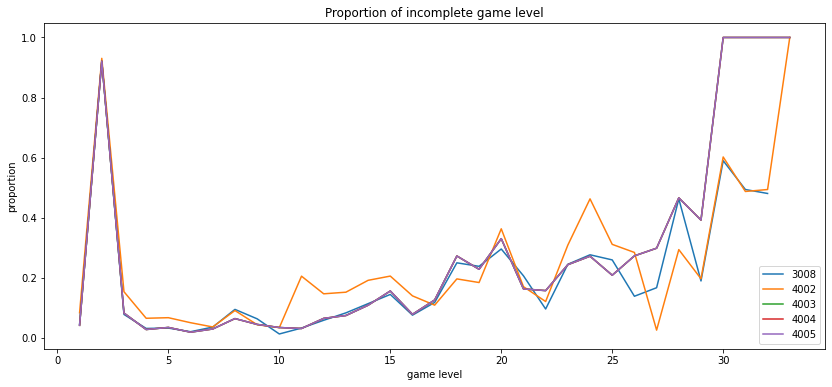

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize =(14,6))
for i in range(len(grp_df)):
    plt.plot(grp_df[i]["new_gameLevel"],grp_df[i]["proportion"], label = grp_df[i]["gameCode"].unique()[0])
plt.xlabel("game level")
plt.ylabel("proportion")
plt.title("Proportion of incomplete game level")
plt.legend()
plt.show()
    

It is surprising that for all files the game level 2 has such a high proportion of incomplete game levels. For game level at and above 30 the gameCode 4002, 4003 and 4005 are all incomplete. There are only two explaination for this either the data stored was lost or the functions that we used to assign the gameID, i.e. unique ID for each game levels played until a new game level was started for each user has a bug. We did find the original file with some incomplete data in one file but not the others so it is reasonable to believe that there is a discrepency in the data collection and storing process. 


In [24]:
#remove incomplete levelsdrop columns that are not needed anymore as well as 
for g in range(len(grp_game_code_dict)):
    grp_game_code_dict[g] = grp_game_code_dict[g][grp_game_code_dict[g]["aliens_matched"] == True]
    grp_game_code_dict[g] = grp_game_code_dict[g].drop(columns = ['max_alienID', 'exp_num_aliens', 
                                                                  'num_alienID','aliens_matched'])



# Assign ruleID 

`gameCode` 4002 has `foodNeeded` column, which indicates change in the rule of the game. We need to assign a unique rule id for each game played when `foodNeeded` changes. But couple of problems that needs to be fixed first. 


In [25]:
# expected number of aliens per gamelevel, any one dataframe should be enought to find this
def cnt_alienID_per_gameLevel(df):
    df_alienID_gameLevel = df.copy()
    df_alienID_gameLevel = df_alienID_gameLevel.loc[:,["gameLevel", "alienID"]]
    df_alienID_gameLevel.gameLevel = df_alienID_gameLevel.gameLevel.str.replace("SpaceCakesLevel ", "")
    df_alienID_gameLevel[['x','y','attempt']] = df_alienID_gameLevel.gameLevel.str.split(pat = "-", expand = True)
    df_alienID_gameLevel['level'] = pd.to_numeric(df_alienID_gameLevel['x'])*5 + pd.to_numeric(df_alienID_gameLevel['y']) + 1
    
    # reorder columns
    col_names = ['level', 'attempt', 'alienID']
    df_alienID_gameLevel = df_alienID_gameLevel.reindex(columns=col_names)

    # count the total number of aliens for each level
    cnt_alienID_gameLevel = pd.DataFrame({'exp_num_aliens': df_alienID_gameLevel.groupby(['level'])['alienID'].max()}).reset_index()
    return cnt_alienID_gameLevel

alienID_gameLevel = cnt_alienID_per_gameLevel(grp_game_code_dict[0])
alienID_gameLevel

exp_alienID_df =alienID_gameLevel.copy()
exp_alienID_df.head()

,level,exp_num_aliens
0,1,30
1,2,60
2,3,60
3,4,30
4,5,30


In [26]:
#list of 33  alienIDs
gameLevels_l = np.arange(1,34).tolist()
#list of number of aliens after which rules change for each level
rule_change_per_aliens_l = [10,10,15,10,10,30,30,20,20,15,40,40,20,20,20,40,40,10,10,10,40,40,20,20,20,40,40,20,20,20,40,40,20]
rule_change_alienID_df = pd.DataFrame({"level": gameLevels_l, 
                                       "rule_change":rule_change_per_aliens_l})
#merge with the expected number of aliens per level
rule_alienID_df = pd.merge(exp_alienID_df, rule_change_alienID_df, on = "level")
#count the number of times rules needs to change
#need to index the n_rules_per_level_l so make it an integer
rule_alienID_df["n_rules_per_level"] = (rule_alienID_df["exp_num_aliens"]/rule_alienID_df["rule_change"]).astype(np.uint8)
rule_alienID_df#.head()


,level,exp_num_aliens,rule_change,n_rules_per_level
0,1,30,10,3
1,2,60,10,6
2,3,60,15,4
3,4,30,10,3
4,5,30,10,3
5,6,30,30,1
6,7,30,30,1
7,8,40,20,2
8,9,40,20,2
9,10,60,15,4


In [27]:
#for each level copy the level the number of times of its expected alienIDs
alienID_l = [np.arange(0, rule_alienID_df.loc[i,"exp_num_aliens"])+1 for i in range(len(rule_alienID_df))] 
print("Example level 1\n")
print("list of alienID:\n", alienID_l[0],"\n")
#grab the list of the number of rules for each level
n_rules_per_level_l = rule_alienID_df["n_rules_per_level"] 
print("list of number of rules:\n", np.array(n_rules_per_level_l[0]),"\n")
#for each level create a new list that contains range of values from 1 to the number of rules
rules_per_level_l = [np.arange(1, n_rules_per_level_l[i]+1) for i in range(len(n_rules_per_level_l))]
print("list of rules:\n", rules_per_level_l[0],"\n")

# split the alienID_l into how ever many rules are expected
grp_aliens_per_level_l = [np.array_split(alienID_l[i], n_rules_per_level_l[i]) for i in range(len(rule_alienID_df))]
print("list of alienID for each rule:\n", grp_aliens_per_level_l[0])


Example level 1

list of alienID:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 

list of number of rules:
 3 

list of rules:
 [1 2 3] 

list of alienID for each rule:
 [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]), array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]


In [28]:
#create a dataframe that contains the list of rules for each level and the list of aliens in each rule
updated_rule_alienID_df = pd.DataFrame({"level": gameLevels_l, 
                      "ruleID":rules_per_level_l, 
                      "alienID":grp_aliens_per_level_l})
updated_rule_alienID_df.head()

,level,ruleID,alienID
0,1,"[1, 2, 3]","[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13,..."
1,2,"[1, 2, 3, 4, 5, 6]","[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13,..."
2,3,"[1, 2, 3, 4]","[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1..."
3,4,"[1, 2, 3]","[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13,..."
4,5,"[1, 2, 3]","[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13,..."


In [29]:
#first explode the rule then alienID
updated_rule_alienID_df=updated_rule_alienID_df.apply(pd.Series.explode).reset_index(drop =True).explode("alienID")
updated_rule_alienID_df.head()

,level,ruleID,alienID
0,1,1,1
0,1,1,2
0,1,1,3
0,1,1,4
0,1,1,5


In [30]:
updated_rule_alienID_df=updated_rule_alienID_df.explode("alienID")
updated_rule_alienID_df.head()

,level,ruleID,alienID
0,1,1,1
0,1,1,2
0,1,1,3
0,1,1,4
0,1,1,5


We can merge the above dataframe to our full dataframes such that ruleID is assigned for each row

In [31]:
def assign_ruleID(df, ruleID_df):
    df_c = df.copy()
    #renamed to match dataframe
    ruleID_df_c = ruleID_df.copy()
    ruleID_df_c=ruleID_df_c.rename(columns={"level":"new_gameLevel"})
    print(ruleID_df_c.columns)
    new_df = pd.merge(df_c, ruleID_df_c, on = ["new_gameLevel", "alienID"], indicator = True) #left_on=["new_gameLevel", "alienID"], right_on=["level", "alienID"])# 
    #there should be a complete match without any left_only and right_only merge types
    print("Expected both only:", new_df["_merge"].unique())
    print("Length should not change:", len(df_c) == len(new_df))
    return new_df

for g in range(len(grp_game_code_dict)):
    grp_game_code_dict[g] = assign_ruleID(grp_game_code_dict[g], updated_rule_alienID_df)
    #_merge is just to make sure we are outputting as expected so get rid of it
    grp_game_code_dict[g] = grp_game_code_dict[g].drop(columns="_merge")
    print("-"*20)

Index(['new_gameLevel', 'ruleID', 'alienID'], dtype='object')
Expected both only: [both]
Categories (1, object): [both]
Length should not change: True
--------------------
Index(['new_gameLevel', 'ruleID', 'alienID'], dtype='object')
Expected both only: [both]
Categories (1, object): [both]
Length should not change: True
--------------------
Index(['new_gameLevel', 'ruleID', 'alienID'], dtype='object')
Expected both only: [both]
Categories (1, object): [both]
Length should not change: True
--------------------
Index(['new_gameLevel', 'ruleID', 'alienID'], dtype='object')
Expected both only: [both]
Categories (1, object): [both]
Length should not change: True
--------------------
Index(['new_gameLevel', 'ruleID', 'alienID'], dtype='object')
Expected both only: [both]
Categories (1, object): [both]
Length should not change: True
--------------------


# Exploratory Data Analysis

Take a step back and do some EDA to identify obvious issues

1. column names for each file within a `game_code` must match and they do
2. generate general stats to makes sure data are as expected for example the alienID must be within a certain range [0,80], gametime cannot be negative
3. `game_code` 4002 has some rows split up into two (complicated game level expects both button to be pressed at the same time (), but two records are made one per button) 


In [32]:
#order in which columns are placed inside sort_values matters
# in the example below the alienID 7 is on the 9th index instead of 6th index
eda_df_4002_c = grp_game_code_dict[1].copy().sort_values(["userID","gameTime","gsUserID","gameLevel","alienID"]).reset_index(drop=True)
eda_df_4002_c.head(10)

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,foodShot,foodNeeded,attempt,new_gameLevel,gameID,ruleID
0,ATHF18,16770,chgir0tcnenmrpkrcuavpqu7t0,e06e6bdf_bde9f3ce9f29,4002,2018-10-30 09:04:28,0-0-0,64.0,1,FOOD,FOOD,1,1,513,1
1,ATHF18,16770,chgir0tcnenmrpkrcuavpqu7t0,e06e6bdf_bde9f3ce9f29,4002,2018-10-30 09:04:31,0-0-0,66.0,2,DRINK,DRINK,1,1,513,1
2,ATHF18,16770,chgir0tcnenmrpkrcuavpqu7t0,e06e6bdf_bde9f3ce9f29,4002,2018-10-30 09:04:32,0-0-0,68.0,3,FOOD,FOOD,1,1,513,1
3,ATHF18,16770,b061847r0mhg66kb35chrbqar2,8a5249dd_9768baa6f43d,4002,2018-10-23 09:24:07,0-0-0,69.0,1,FOOD,FOOD,1,1,176,1
4,ATHF18,16770,b061847r0mhg66kb35chrbqar2,8a5249dd_9768baa6f43d,4002,2018-10-23 09:24:09,0-0-0,70.0,2,FOOD,FOOD,1,1,176,1
5,ATHF18,16770,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,4002,2018-10-23 09:05:34,0-0-0,70.0,1,FOOD,FOOD,1,1,654,1
6,ATHF18,16770,chgir0tcnenmrpkrcuavpqu7t0,e06e6bdf_bde9f3ce9f29,4002,2018-10-30 09:04:36,0-0-0,71.0,4,DRINK,DRINK,1,1,513,1
7,ATHF18,16770,b061847r0mhg66kb35chrbqar2,8a5249dd_9768baa6f43d,4002,2018-10-23 09:24:11,0-0-0,72.0,3,FOOD,FOOD,1,1,176,1
8,ATHF18,16770,chgir0tcnenmrpkrcuavpqu7t0,e06e6bdf_bde9f3ce9f29,4002,2018-10-30 09:04:37,0-0-0,72.0,5,FOOD,FOOD,1,1,513,1
9,ATHF18,16770,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,4002,2018-10-23 09:05:37,0-0-0,73.0,2,DRINK,DRINK,1,1,654,1


In [33]:
#Therefore, always use the sort arguments below unless necessary: `.sort_values(["userID","gsUserID","gameTime","gameLevel","alienID"]).reset_index(drop=True)`
eda_df_4002_c = grp_game_code_dict[1].copy().sort_values(["userID","gsUserID","gameTime","gameLevel","alienID"]).reset_index(drop=True)
print("total number of rows in 4002:", len(eda_df_4002_c))
eda_df_4002_c.head(10)

total number of rows in 4002: 248395


,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,foodShot,foodNeeded,attempt,new_gameLevel,gameID,ruleID
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:54,2-0-1,136.0,1,FOOD,FOOD,2,11,56,1
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:55,2-0-1,137.0,2,DRINK,FOOD/DRINK,2,11,56,1
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:55,2-0-1,137.0,2,FOOD,FOOD,2,11,56,1
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:56,2-0-1,139.0,3,DRINK,DRINK,2,11,56,1
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:59,2-0-1,141.0,4,FOOD,FOOD/DRINK,2,11,56,1
5,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:59,2-0-1,141.0,4,DRINK,DRINK,2,11,56,1
6,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:00,2-0-1,142.0,5,DRINK,FOOD,2,11,56,1
7,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:02,2-0-1,144.0,6,FOOD,FOOD,2,11,56,1
8,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:04,2-0-1,146.0,7,FOOD,FOOD/DRINK,2,11,56,1
9,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:06,2-0-1,148.0,7,FOOD,DRINK,2,11,56,1


In [34]:
eda_df_4002_c[eda_df_4002_c["gsUserID"] == "c2603fd4_1121ef4b129b"]

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,foodShot,foodNeeded,attempt,new_gameLevel,gameID,ruleID


In [35]:
## keep it as EDA
# 1.
#make a list of lists with filenames with common game_code in one list 
grp_game_code_list = grp_files_param(file_names, game_code)
#print(grp_game_code_list)

def compare_colnames(grp_filename_list):
    for g in grp_filename_list:
        lst_cols = []
        for i in range(len(g)):
            df = pd.read_csv(g[i])
            lst_cols.append(df.columns.values)
            if len(lst_cols) > 0 and (lst_cols[i] == lst_cols[i-1]).all() == False:
                print('mismatched columns')
                a = set(lst_cols[i])
                b = set(lst_cols[i-1])
                print(g[i], list(b - a))
                print(g[i-1],list(a - b))
            else:
                #print('matched columns')
                a = set(lst_cols[i])
                b = set(lst_cols[i-1])
                #print(g[i], list(a))
                #print(g[i-1],list(b))
                 
#compare column names within common game_code 
compare_colnames(grp_game_code_list)  

#testing if the function works as expected
#compare_colnames([['ATM1F18_ayce_3008.csv','ATM1F18_ayce_4002.csv']])

In [36]:
## keep it as EDA
# 2.
# noticed 4005 have negative posY

def general_stats(grp_filename_list):
    for g in grp_game_code_list:
        for f in g:
            df = pd.DataFrame(pd.read_csv(f))
            print(f)
            print("-"*20)
            stats = pd.DataFrame(df.describe())
            stats = stats.filter(items = ['min','max','mean'], axis=0)
            print(stats)
            print("-"*80)
        
general_stats(grp_game_code_list)

ATM1F18_ayce_3008.csv
--------------------
            userID  participantID  gameCode         logID        jotID  \
min     115.000000            NaN    3008.0  1.376634e+06    11.000000   
max   18572.000000            NaN    3008.0  5.028107e+06  6636.000000   
mean  17282.502786            NaN    3008.0  3.374551e+06  1678.967769   

          gameTime    alienID        posX        posY  
min   1.428800e+04   1.000000  154.000000  764.000000  
max   1.754243e+06  80.000000  870.000000  806.000000  
mean  5.927122e+05  25.318042  512.142445  804.237723  
--------------------------------------------------------------------------------
ATHBF18_ayce_3008.csv
--------------------
            userID  participantID  gameCode         logID        jotID  \
min   16845.000000            NaN    3008.0  1.688973e+06    11.000000   
max   16908.000000            NaN    3008.0  4.678957e+06  7404.000000   
mean  16873.050341            NaN    3008.0  2.858299e+06  1636.338332   

          gameT

ATMBF18_ayce_4004.csv
--------------------
            userID  participantID  gameCode         logID        jotID  \
min   17058.000000            NaN    4004.0  1.803347e+06    15.000000   
max   18592.000000            NaN    4004.0  5.111332e+06  6117.000000   
mean  17364.705219            NaN    4004.0  3.620179e+06  1505.118532   

          gameTime    alienID  reactionTime  eyeReactionTime  \
min   1.591900e+04   1.000000       0.00000         0.000000   
max   1.612428e+06  80.000000      18.56981        18.269590   
mean  5.245499e+05  24.725247       1.62868         1.318149   

      afterHighlightedReactionTime  
min                       0.000000  
max                      18.569810  
mean                      1.193395  
--------------------------------------------------------------------------------
ATHBF18_ayce_4004.csv
--------------------
            userID  participantID  gameCode         logID        jotID  \
min   16845.000000            NaN    4004.0  1.688981e+06

In [37]:
## keep it as EDA
df_3008 = pd.read_csv(os.path.join(my_path, 'ATM1F18_ayce_3008.csv'))

filter_df = df_3008[(df_3008['accessCode'] == 'ATM1F18') 
        & (df_3008['userID']== 16948 )  
        & (df_3008['sesID']== 'df192h3fubauhvdmj99qsnf5g7')
       & (df_3008['gameLevel']== 'SpaceCakesLevel 3-1-0')]

#uncomment below to see same alien id logged twice
#filter_df.sort_values(["userID","logTimestamp","alienID"]).reset_index(drop =True)
## keep it as EDA
#filter_df.sort_values(["userID","gameTime","alienID"]).reset_index(drop =True)

### 2 a) Issue with 4003, 4004 and 4005

Testing different merge keys using and not using `logTimestamp`.

| Between | Don't use `logTimestamp` nor `gameTime`| use `logTimestamp` | use `gameTime` in seconds |
| --- | --- | --- | --- |
| 4003 and 4004 | both inner and outer gives +572 rows | outer merge gives +3425 rows; inner merge gives -3425 rows | outer merge gives +208 rows; inner merge gives -144 rows |
| 4003 and 4005 | both inner and outer gives +572 rows | outer merge gives +6482 rows; inner merge gives -6482 rows |  outer merge gives +342 rows; inner merge gives -278 rows |
| 4004 and 4005 | both inner and outer gives +572 rows | outer merge gives +3057 rows; inner merge gives -3057 rows|  outer merge gives +166 rows; inner merge gives -102 rows |

If we dont use `logTimestamp` and `gameTime` both inner and outer merge are producing 1728 more rows than initial rows, this is because there are multiple attempts made by a user for the same `gameLevel` and since `sesID` and `gsUserID` don't change we have one-to-many mapping.  

There are cases where the `logTimestamp` are different accross `gameCode` therefore we see fewer match. `gameTime` produced more match than `logTimestamp` and it was more consistent so we decided to use `gameTime` when merging the files. `gameTime` was stored in milliseconds, which we converted to seconds to match more rows without negative impact.  

We did use the mismatch of the `logTimestamp` to find some issues. For example when there was a mismatch, the `logTimestamp` of 4003 was always one seconds before the `logTimestamp` of 4004, so for the rows where inner merge didn't happen we added one second for 4003 and all rows matched. The `logTimestamp` of 4003 can be one seconds before or after the `logTimestamp` of 4005. 

While using `gameTime` in seconds to merge the files, we noticed two issues:

### 2 a.1) issue with multiple records/rows for selected keys
For some of the rows the keys that we used to merge different `game_code` had more than one record. So, we had to check which rows had such issue. 

### 2 a.2) issue with missing records/rows for selected keys
For some of the rows the keys were not matching because for slight difference in `gameTime`

In [38]:
def prn_game_code_uniq(df):
    print("Shape of game code", df['gameCode'].unique(), ":", df.shape)
    
def prn_merge_detail(df1, df2, merged_df):
    df1_c= df1.copy()
    df2_c = df2.copy()
    #print("Types of merge:", merged_df["_merge"].unique())
    if ('gameCode' in df1_c.columns) & ('gameCode' in df2_c.columns): 
        prn_game_code_uniq(df1_c)
        prn_game_code_uniq(df2_c)
    elif 'gameCode' in df1_c.columns: 
        prn_game_code_uniq(df1_c)
    elif 'gameCode' in df2_c.columns: 
        prn_game_code_uniq(df2_c)
        
    #the difference in rows shows the issue 2 a.2) 
    print("Shape of merged :", merged_df.shape)
    dif_df1 = merged_df.shape[0] - df1_c.shape[0]
    dif_df2 = merged_df.shape[0] - df2_c.shape[0]
    print("Difference in rows between merged dataframe and df1 :", dif_df1)
    print("Difference in rows between merged dataframe and df2 :", dif_df2)
    print("-"*100)
    n_both = len(merged_df[merged_df["_merge"] == "both"])
    n_left = len(merged_df[merged_df["_merge"] == "left"])
    n_right = len(merged_df[merged_df["_merge"] == "right"])
    
    #shows issue 2 a.1) i.e. multiple rows for the keys that were selected hence the number of records not matching
    print("We expected the number rows between left and inner as well as right and inner to match and we got\n",
          (len(merged_df)+n_right == df1_c.shape[0]), (len(merged_df)+n_left == df2_c.shape[0])) 
    print("-"*100)
    
def merge_dfs(df1, df2, merge_type = 'outer', use = "None", show_merge_type=True, use_gameID = False):
    """
    input: two dataframes
    output: merged dataframe joined based on keys listed in the code
    """
    df1_c= df1.copy()
    df2_c = df2.copy()
    if use == "None":
        if use_gameID == False:
            merge_keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', "attempt", 
                             "new_gameLevel",'ruleID']
        else: 
            merge_keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', "attempt", 
                             "new_gameLevel", "gameID",'ruleID']
    elif use == "logTimestamp":
        if use_gameID == False:
            merge_keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', 'logTimestamp',
                             "attempt", "new_gameLevel",'ruleID']
        else: 
            merge_keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', 'logTimestamp',
                             "attempt", "new_gameLevel","gameID",'ruleID'] 
        print("-"*10, "\nlogTimestamp\n", "-"*10)
    elif use == "gameTime":
        if use_gameID == False:
            merge_keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', 'gameTime',
                             "attempt", "new_gameLevel",'ruleID']
        else: 
            merge_keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', 'gameTime',
                             "attempt", "new_gameLevel","gameID",'ruleID']
        print("-"*10, "\ngameTime\n", "-"*10)
    merged_df = pd.merge(df1_c, df2_c, 
                         on=merge_keys, 
                         how=merge_type, 
                         indicator=show_merge_type) 
    prn_merge_detail(df1, df2, merged_df)
    return merged_df
    
#number of rows below is not matching the original dataframe before merge hence we know that there are multiple 
#records per keys selected
l_dict = [[2,3],[2,4],[3,4]]

for l in l_dict:
    #check_df = merge_dfs(grp_game_code_dict[l[0]], grp_game_code_dict[l[1]], merge_type = 'outer',use = "None")
    #check_df = merge_dfs(grp_game_code_dict[l[0]], grp_game_code_dict[l[1]], merge_type = 'inner',use = "None")
    
    #check_df = merge_dfs(grp_game_code_dict[l[0]], grp_game_code_dict[l[1]], merge_type = 'outer',use = "logTimestamp")
    #check_df = merge_dfs(grp_game_code_dict[l[0]], grp_game_code_dict[l[1]], merge_type = 'inner', use = "logTimestamp")
    
    check_df = merge_dfs(grp_game_code_dict[l[0]], grp_game_code_dict[l[1]], 
                         merge_type = 'outer',
                         use = "gameTime")
    check_df = merge_dfs(grp_game_code_dict[l[0]], grp_game_code_dict[l[1]], 
                         merge_type = 'inner',
                         use = "gameTime")
    
#once keys are figured out the below code can be commented out to merge all dataframes
#for i in range(2, len(grp_game_code_dict)):
#    merged_df = merge_dfs(merged_df, grp_game_code_dict[i])
#    print("-"*20)

---------- 
gameTime
 ----------
Shape of game code [4003] : (209652, 18)
Shape of game code [4004] : (209652, 16)
Shape of merged : (209860, 25)
Difference in rows between merged dataframe and df1 : 208
Difference in rows between merged dataframe and df2 : 208
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 False False
----------------------------------------------------------------------------------------------------
---------- 
gameTime
 ----------
Shape of game code [4003] : (209652, 18)
Shape of game code [4004] : (209652, 16)
Shape of merged : (209508, 25)
Difference in rows between merged dataframe and df1 : -144
Difference in rows between merged dataframe and df2 : -144
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well a

### 2 a.1) issue with multiple records/rows for selected keys

Goal is to select the data frame if the keys selected have more than one rows. There might be shorter way to do what we are doing below.

1) group the dataframe based on selected keys 

2) use `cumcount()` function to cumulatively add number if same keys before that row

3) find the indices where the `cumcount()` is greater than 0

4) create a new dataframe with the selected columns from the indices and add a new column called "marker"

5) merge the new datadrame with the original dataframe so that we can filter the rows with the "marker" defined

Filtering the dataframe 

we noticed that some records of alienID were repeated with different `logTimestamp` so we removed all but the first occurance if everything except for `logTimestamp` column is the same using `drop_dup_timestamp(df)`

- 42724  duplicates for 4002 is expected because when `foodNeeded` == "FOOD/DRINK" we might have two rows discussed further later

In [39]:
## keep it as EDA
def check_multiple_keys(df, use = "None"):
    df_c = df.copy()
    if use == "None":
        keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID','ruleID']
    elif use == "logTimestamp":
        keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', 'logTimestamp','ruleID']
    elif use == "gameTime":
        keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameTime', 'gameLevel', 'alienID','ruleID']
    grp_df= df_c.groupby(keys).cumcount()
    #get a list of indices where there is more than one records given the grouby 
    ind_multiple = grp_df[grp_df>0].index    
    #given the index print the dataframe where the values of groupby matches
    match_df = df_c.loc[ind_multiple, keys]
    #print(match_df)
    match_df['marker'] = 1
    joined = pd.merge(df_c, match_df, on=keys, how='left')
    filter_joined = joined[joined['marker'] == 1].sort_values(by = ["userID","gsUserID","gameTime","gameLevel","alienID"])
    return  filter_joined
        
for i in range(5):
    print(grp_game_code_dict[i]['gameCode'].unique())
    print("number of records with multiple rows per keys", len(check_multiple_keys(grp_game_code_dict[i], use = "gameTime")),"\n")
    print("-"*80)
    

[3008]
number of records with multiple rows per keys 26 

--------------------------------------------------------------------------------
[4002]
number of records with multiple rows per keys 42724 

--------------------------------------------------------------------------------
[4003]
number of records with multiple rows per keys 32 

--------------------------------------------------------------------------------
[4004]
number of records with multiple rows per keys 32 

--------------------------------------------------------------------------------
[4005]
number of records with multiple rows per keys 32 

--------------------------------------------------------------------------------


In [40]:
## keep it as EDA
test_0 = grp_game_code_dict[0].copy()
test_0 = test_0[(test_0['userID'] == 16785)&(test_0['gsUserID'] == 'b5391b8e_f5cbfb91505a')&(test_0['gameLevel'] == '2-2-0')]
test_0

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,spawnPosX,spawnPosY,attempt,new_gameLevel,gameID,ruleID
121155,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:03:30,2-2-0,221.0,1,477,806,1,13,9689,1
121402,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:03:31,2-2-0,223.0,2,756,806,1,13,9689,1
121649,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:03:34,2-2-0,225.0,3,724,806,1,13,9689,1
121896,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:03:36,2-2-0,227.0,4,806,804,1,13,9689,1
122143,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:03:38,2-2-0,229.0,5,206,804,1,13,9689,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134741,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:06:14,2-2-0,385.0,56,485,804,1,13,9689,3
134988,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:06:16,2-2-0,387.0,57,856,804,1,13,9689,3
135235,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:06:17,2-2-0,389.0,58,794,804,1,13,9689,3
135482,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:06:19,2-2-0,390.0,59,329,806,1,13,9689,3


In [41]:
test_0 = check_multiple_keys(grp_game_code_dict[0], use = "gameTime")
test_0.head()

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,spawnPosX,spawnPosY,attempt,new_gameLevel,gameID,ruleID,marker
125107,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:03:59,2-2-0,251.0,17,187,804,1,13,9689,1,1.0
125108,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:04:20,2-2-0,251.0,17,187,804,1,13,9689,1,1.0
136201,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:07:33,2-3-0,464.0,2,290,804,1,14,9750,1,1.0
136202,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:19:06,2-3-0,464.0,2,290,804,1,14,9750,1,1.0
182783,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,3008,2018-11-15 09:15:19,3-0-0,926.0,20,492,804,1,16,9891,1,1.0


In [42]:
## keep it as EDA
#additional issue with 3008 where two records of "foodNeeded" == "FOOD/DRINK" and "DRINK" 
test_1 = check_multiple_keys(grp_game_code_dict[1], use = "gameTime")
test_1.head()

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,foodShot,foodNeeded,attempt,new_gameLevel,gameID,ruleID,marker
369,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:55,2-0-1,137.0,2,DRINK,FOOD/DRINK,2,11,56,1,1.0
370,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:55,2-0-1,137.0,2,FOOD,FOOD,2,11,56,1,1.0
1470,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:59,2-0-1,141.0,4,FOOD,FOOD/DRINK,2,11,56,1,1.0
1471,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:59,2-0-1,141.0,4,DRINK,DRINK,2,11,56,1,1.0
3686,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:07,2-0-1,149.0,8,FOOD,FOOD/DRINK,2,11,56,1,1.0


## Solution for 2 a.1)

In [43]:
def drop_dup_timestamp(df):
    """
    param: dataframe
    return: remove the second occurance of `logTimestamp` if every other columns are the same, also drop `aliens_match` column
    """
    df_c = df.copy()
    cols = df.columns.tolist()
    # keep the row with first timestamp if every column is the same except for the "logTimestamp"
    select_cols =[ele for ele in cols if ele not in ['logTimestamp']]
    #print(select_cols)
    new_df = df.drop_duplicates(subset=select_cols, keep = 'first').reset_index(drop =True)
    print('droped', len(df) - len(new_df), "rows with multiple records for same alien" )
    print("new dataframe has", len(new_df))
    #new_df= new_df.drop(columns= 'aliens_match')
    return new_df 

for g in range(len(grp_game_code_dict)):
    grp_game_code_dict[g] = drop_dup_timestamp(grp_game_code_dict[g])
    print("-"*20)

droped 13 rows with multiple records for same alien
new dataframe has 210609
--------------------
droped 18 rows with multiple records for same alien
new dataframe has 248377
--------------------
droped 16 rows with multiple records for same alien
new dataframe has 209636
--------------------
droped 16 rows with multiple records for same alien
new dataframe has 209636
--------------------
droped 16 rows with multiple records for same alien
new dataframe has 209636
--------------------


In [44]:
## keep it as EDA
merged_df_4003_4004 = merge_dfs(grp_game_code_dict[2], grp_game_code_dict[3], use = "gameTime")

merged_df_4004_4005 = merge_dfs(grp_game_code_dict[3], grp_game_code_dict[4], use = "gameTime")

merged_df_4003_4005 = merge_dfs(grp_game_code_dict[2], grp_game_code_dict[4], use = "gameTime")


---------- 
gameTime
 ----------
Shape of game code [4003] : (209636, 18)
Shape of game code [4004] : (209636, 16)
Shape of merged : (209812, 25)
Difference in rows between merged dataframe and df1 : 176
Difference in rows between merged dataframe and df2 : 176
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 False False
----------------------------------------------------------------------------------------------------
---------- 
gameTime
 ----------
Shape of game code [4004] : (209636, 16)
Shape of game code [4005] : (209636, 16)
Shape of merged : (209770, 23)
Difference in rows between merged dataframe and df1 : 134
Difference in rows between merged dataframe and df2 : 134
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as 

### 2 a.2) issue with missing records/rows for selected keys
For some of the rows the keys we were not matching because for slight difference in `gameTime`. 

As you can see in the example below when `gameCode` is 4003 we need to add one second in the column "gameTime". The "gameTime" for `gameCode` 4004 and 4005 matches. 

In [45]:
## keep it as EDA
def test_filter_df(df):
    df_c = df.copy()
    df_c = df_c[(df_c['userID'] == 16770)& 
         (df_c['gsUserID'] == "ce0863b3_21c6d4a0e2f4")& 
         (df_c['gameLevel'] == "2-0-1")&
         (df_c['alienID'] == 16)]
    return df_c

test_filter_df(merged_df_4003_4004)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,alienColor,gameID_x,ruleID,gameCode_y,logTimestamp_y,reactionTime,eyeReactionTime,afterHighlightedReactionTime,gameID_y,_merge
7210,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4003.0,2018-11-15 09:04:47,2-0-1,273.0,16.0,"OneEyed,Red",...,Red,331.0,1.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
209638,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,NaN,NaT,2-0-1,274.0,16.0,NaN,...,NaN,NaN,1.0,4004.0,2018-11-15 09:04:47,1.568025,1.26763,1.568025,331.0,right_only


In [46]:
## keep it as EDA
test_filter_df(merged_df_4004_4005)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,reactionTime,...,new_gameLevel,gameID_x,ruleID,gameCode_y,logTimestamp_y,hitPosX,hitPosY,oldReactionTime,gameID_y,_merge
7210,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4004.0,2018-11-15 09:04:47,2-0-1,274.0,16.0,1.568025,...,11,331.0,1.0,4005.0,2018-11-15 09:04:47,779.0,609.0,0.6168,331.0,both


In [47]:
## keep it as EDA
test_filter_df(merged_df_4003_4005)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,alienColor,gameID_x,ruleID,gameCode_y,logTimestamp_y,hitPosX,hitPosY,oldReactionTime,gameID_y,_merge
7210,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4003.0,2018-11-15 09:04:47,2-0-1,273.0,16.0,"OneEyed,Red",...,Red,331.0,1.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
209640,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,NaN,NaT,2-0-1,274.0,16.0,NaN,...,NaN,NaN,1.0,4005.0,2018-11-15 09:04:47,779.0,609.0,0.6168,331.0,right_only


In [48]:
#need to modify delta_gameTime() such that it can take values dynamically
    
def delta_gameTime(df, merge_type, gameCode_f, add_remove):
    """
    param df: dataframe to change gameTime
    param merge_type: filter based on merge type either 'left_only', 'right_only' or 'both_only'
    param gameCode_f: filter based on gameCode entered
    param add_remove: add one second or subtract one second based on whether "add" or "remove"
    """
    df_c = df.copy()
    if add_remove == "add":
        if merge_type == 'left_only':
            df_c.loc[(df_c['_merge']=='left_only')&(df_c['gameCode_x']==gameCode_f), 'gameTime'] = df_c['gameTime'] +1
            #+ datetime.timedelta(seconds= 1) 
        elif merge_type == 'right_only':
            df_c.loc[(df_c['_merge']=='right_only')&(df_c['gameCode_y']==gameCode_f), 'gameTime'] = df_c['gameTime'] +1
    elif add_remove == "remove":
        if merge_type == 'left_only':
            df_c.loc[(df_c['_merge']=='left_only')&(df_c['gameCode_x']==gameCode_f), 'gameTime'] = df_c['gameTime'] -1 
        elif merge_type == 'right_only':
            df_c.loc[(df_c['_merge']=='right_only')&(df_c['gameCode_y']==gameCode_f), 'gameTime'] = df_c['gameTime'] -1 
    return df_c
    
def merge_delta_lr(merged_df, replace_col_xy = True, use_gameID=False):
    #merged_df_c = delta_gameTime(merged_df, merge_type="left_only", gameCode_f=4003, add_remove= "add")
    merged_df_c = merged_df.copy()
    both_df = merged_df_c.loc[merged_df_c['_merge']=='both']
    
    left_df = merged_df_c.loc[merged_df_c['_merge']=='left_only'].dropna(axis=1).drop(columns = '_merge')
    if replace_col_xy == True:
        left_df.columns = left_df.columns.str.replace("_x", "")
    print(len(merged_df.loc[merged_df['_merge']=='left_only'])==len(left_df))

    right_df = merged_df_c.loc[merged_df_c['_merge']=='right_only'].dropna(axis=1).drop(columns = '_merge')
    if replace_col_xy == True:
        right_df.columns = right_df.columns.str.replace("_y", "")
    print(len(merged_df.loc[merged_df['_merge']=='right_only'])==len(right_df))
    
    lr_df = merge_dfs(left_df, right_df, use = "gameTime", show_merge_type=True,use_gameID=use_gameID)
    print("left and right merged df", len(lr_df))
    #print(both_df.columns)
    #print(lr_df.columns)
    final_merged_df = pd.concat([both_df,lr_df ])
    print(final_merged_df['_merge'].unique().tolist())
    #drop "_merge" column if all values is "both" so that we can add a third dataframe
    if (final_merged_df['_merge'] == "both").all() == True:
        final_merged_df=final_merged_df.drop(columns = "_merge")
    return final_merged_df


merged_df_4003_4004 = merge_dfs(grp_game_code_dict[2], grp_game_code_dict[3], 
                                use = "gameTime", 
                                show_merge_type=True)

#merge_dfs(convert_gameTime(grp_game_code_dict[2]), convert_gameTime(grp_game_code_dict[3]), use = "gameTime", show_merge_type=True)
d_merged_df_4003_4004 = delta_gameTime(merged_df_4003_4004, merge_type="left_only", gameCode_f=4003, add_remove= "add")
clean_merged_df_4003_4004 = merge_delta_lr(d_merged_df_4003_4004)
clean_merged_df_4003_4004.head()

---------- 
gameTime
 ----------
Shape of game code [4003] : (209636, 18)
Shape of game code [4004] : (209636, 16)
Shape of merged : (209812, 25)
Difference in rows between merged dataframe and df1 : 176
Difference in rows between merged dataframe and df2 : 176
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 False False
----------------------------------------------------------------------------------------------------
True
True
---------- 
gameTime
 ----------
Shape of game code [4003.] : (176, 18)
Shape of game code [4004.] : (176, 16)
Shape of merged : (176, 25)
Difference in rows between merged dataframe and df1 : 0
Difference in rows between merged dataframe and df2 : 0
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as r

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,alienType,alienColor,gameID_x,ruleID,gameCode_y,logTimestamp_y,reactionTime,eyeReactionTime,afterHighlightedReactionTime,gameID_y
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:30,2-0-0,52.0,1.0,"TwoEyed,Blue",...,TwoEyed,Blue,11.0,1.0,4004.0,2018-11-15 09:09:30,2.535415,2.235645,2.535415,11.0
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:10:54,2-0-1,136.0,1.0,"OneEyed,Red",...,OneEyed,Red,51.0,1.0,4004.0,2018-11-15 09:10:54,0.451075,0.150060,0.451075,51.0
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:12:19,2-0-2,221.0,1.0,"TwoEyed,Blue",...,TwoEyed,Blue,91.0,1.0,4004.0,2018-11-15 09:12:19,0.100020,0.000000,0.100020,91.0
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4003.0,2018-11-15 09:02:53,2-0-0,159.0,1.0,"OneEyed,Red",...,OneEyed,Red,291.0,1.0,4004.0,2018-11-15 09:02:53,1.368159,1.068290,1.368159,291.0
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4003.0,2018-11-15 09:04:21,2-0-1,246.0,1.0,"TwoEyed,Red",...,TwoEyed,Red,331.0,1.0,4004.0,2018-11-15 09:04:21,1.283775,0.983465,1.283775,331.0


In [49]:
#need to rename logTimestamp, gameCode from the third dataframe otherwise it will produce an error when trying
# to merge
df_4005 = grp_game_code_dict[4].rename(columns={"logTimestamp": "logTimestamp_z", "gameCode":"gameCode_z", "gameID":"gameID_z"})
print(len(df_4005))
print(len(clean_merged_df_4003_4004))

merged_df_4003_4004_4005 =  merge_dfs(clean_merged_df_4003_4004, df_4005, use = "gameTime", show_merge_type=True)
print(len(merged_df_4003_4004_4005))
merged_df_4003_4004_4005.head()

209636
209636
---------- 
gameTime
 ----------
Shape of merged : (209770, 31)
Difference in rows between merged dataframe and df1 : 134
Difference in rows between merged dataframe and df2 : 134
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 False False
----------------------------------------------------------------------------------------------------
209770


,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,eyeReactionTime,afterHighlightedReactionTime,gameID_y,gameCode_z,logTimestamp_z,hitPosX,hitPosY,oldReactionTime,gameID_z,_merge
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:30,2-0-0,52.0,1.0,"TwoEyed,Blue",...,2.235645,2.535415,11.0,4005.0,2018-11-15 09:09:30,856.0,441.0,1.600800,11.0,both
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:10:54,2-0-1,136.0,1.0,"OneEyed,Red",...,0.150060,0.451075,51.0,4005.0,2018-11-15 09:10:54,838.0,735.0,0.000000,51.0,both
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:12:19,2-0-2,221.0,1.0,"TwoEyed,Blue",...,0.000000,0.100020,91.0,4005.0,2018-11-15 09:12:19,156.0,744.0,0.000000,91.0,both
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4003.0,2018-11-15 09:02:53,2-0-0,159.0,1.0,"OneEyed,Red",...,1.068290,1.368159,291.0,4005.0,2018-11-15 09:02:53,703.0,670.0,0.333495,291.0,both
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4003.0,2018-11-15 09:04:21,2-0-1,246.0,1.0,"TwoEyed,Red",...,0.983465,1.283775,331.0,4005.0,2018-11-15 09:04:21,718.0,599.0,0.349415,331.0,both


In [50]:
## keep it as EDA
merged_df_4003_4004_4005[merged_df_4003_4004_4005['_merge'] == "left_only"]

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,eyeReactionTime,afterHighlightedReactionTime,gameID_y,gameCode_z,logTimestamp_z,hitPosX,hitPosY,oldReactionTime,gameID_z,_merge
124,ATHBF18,16863,i2tp3v7pmfkrgdrt5uf01bb521,eddb044c_c374d80ffe70,4003.0,2018-11-13 13:18:57,2-0-0,35.0,1.0,"TwoEyed,Red",...,0.884350,1.183700,58663.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
3378,ATHF18,16773,rcjcd8egk9rabqu5uqu2t0rmp5,3fd6c4c1_92b7405a9b98,4003.0,2018-11-20 09:17:55,2-0-0,32.0,8.0,"OneEyed,Blue",...,2.185585,0.784030,1999.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
9556,ATMBF18,17665,5m7eja8h8j2f2fl10faagqu2k2,c74e5461_39b6663e9426,4003.0,2018-11-20 13:56:15,2-0-1,211.0,20.0,"TwoEyed,Blue",...,0.450520,0.751900,225193.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
10057,ATMBF18,17671,7lllnmi45ab8iat6vvb5vsnq85,6f517768_7407b7860f2d,4003.0,2018-11-13 14:07:18,2-0-4,554.0,21.0,"TwoEyed,Blue",...,2.586260,0.735130,229986.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
12896,ATMBF18,17640,b33198a4oals1fbhcf9crt2ul7,f7bf701e_3f0c557ca18a,4003.0,2018-11-13 13:15:47,2-0-1,222.0,27.0,"OneEyed,Red",...,1.368180,1.685490,218737.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203489,ATMBF18,17061,jf8n4bada7g3jq81tbmldvlkq4,99918bb2_f899a38155ca,4003.0,2018-11-28 09:07:32,3-3-0,1213.0,37.0,"TwoEyed,Red",...,3.139699,3.013499,133910.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
203615,ATMBF18,17683,aodfsh07atnj778sqjt8tur4a4,7eb1223c_13c9b8ef35bc,4003.0,2018-11-27 14:31:31,3-3-0,452.0,38.0,"OneEyed,Red",...,2.369225,1.285875,232547.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
204545,ATHBF18,16857,plv6j0jlfq7jst2jkmk8pme5u6,8ea8266b_9576872a5c68,4003.0,2018-11-13 13:32:21,3-3-0,1576.0,50.0,"OneEyed,Blue",...,3.157109,1.805500,53856.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
205336,ATM1F18,17577,bblavcivdfe7dvbpuajjplcgp2,28366957_d231a4323a6e,4003.0,2018-11-27 10:28:23,3-3-0,810.0,59.0,"TwoEyed,Red",...,2.135805,0.283660,192838.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only


In [51]:
## keep it as EDA
def test_filter_df(df):
    df_c = df.copy()
    df_c = df_c[(df_c['userID'] == 16770)& 
         (df_c['gsUserID'] == "e0c28c43_bdeea2049114")& 
         (df_c['gameLevel'] == "1-2-0")&
         (df_c['alienID'] == 24)]
    return df_c

test_filter_df(merged_df_4003_4004_4005)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,eyeReactionTime,afterHighlightedReactionTime,gameID_y,gameCode_z,logTimestamp_z,hitPosX,hitPosY,oldReactionTime,gameID_z,_merge
113399,ATHF18,16770,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,4003.0,2018-10-23 09:17:56,1-2-0,812.0,24.0,"OneEyed,Red",...,0.4338,0.734,801.0,NaN,NaT,NaN,NaN,NaN,NaN,left_only
209701,ATHF18,16770,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,NaN,NaT,1-2-0,813.0,24.0,NaN,...,NaN,NaN,NaN,4005.0,2018-10-23 09:17:56,250.0,664.0,0.0,801.0,right_only


In [52]:
d_merged_df_4003_4004_4005 = delta_gameTime(merged_df_4003_4004_4005, merge_type="left_only", gameCode_f=4003,
                                            add_remove= "add")

clean_merged_df_4003_4004_4005 = merge_delta_lr(d_merged_df_4003_4004_4005, replace_col_xy = False).sort_values(["userID","gsUserID","gameTime","gameLevel","alienID"]).reset_index(drop=True)

True
True
---------- 
gameTime
 ----------
Shape of merged : (134, 31)
Difference in rows between merged dataframe and df1 : 0
Difference in rows between merged dataframe and df2 : 0
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 True True
----------------------------------------------------------------------------------------------------
left and right merged df 134
['both']


In [53]:
print("number of rows in the dateframe with 4003 4004 and 4005:", len(clean_merged_df_4003_4004_4005))
print("number of rows in the dateframe with 4003 and 4004:",len(clean_merged_df_4003_4004))

number of rows in the dateframe with 4003 4004 and 4005: 209636
number of rows in the dateframe with 4003 and 4004: 209636


In [54]:
for g in range(2,5):
    print(len(grp_game_code_dict[g]))
    print(len(grp_game_code_dict[g]["gameID"].unique()))

209636
4756
209636
4756
209636
4756


In [55]:
print(clean_merged_df_4003_4004_4005.columns)

Index(['accessCode', 'userID', 'sesID', 'gsUserID', 'gameCode_x',
       'logTimestamp_x', 'gameLevel', 'gameTime', 'alienID',
       'alienTypeAndColor', 'hitType', 'speed', 'attempt', 'new_gameLevel',
       'alienType', 'alienColor', 'gameID_x', 'ruleID', 'gameCode_y',
       'logTimestamp_y', 'reactionTime', 'eyeReactionTime',
       'afterHighlightedReactionTime', 'gameID_y', 'gameCode_z',
       'logTimestamp_z', 'hitPosX', 'hitPosY', 'oldReactionTime', 'gameID_z'],
      dtype='object')


**We performed data manipulation to merge the gameCode 4003 4004 and 4005 into one, but did not further reduce the number of rows.** 

All of the `gameID` for 4003 4004 and 4005 matched, which means we did the sorting and assigning the ids correctly. We can remove two of the gameIDs. 

Final clean version of the combined file is `final_merged_df_4003_4004`

In [56]:
gameID_cols = ['gameID_x','gameID_y','gameID_z']
clean_merged_df_4003_4004_4005['gameID_Match'] = clean_merged_df_4003_4004_4005[gameID_cols].eq(clean_merged_df_4003_4004_4005[gameID_cols[0]], axis=0).all(axis=1)
clean_merged_df_4003_4004_4005.groupby('gameID_Match')['gameID_Match'].count()
if len(clean_merged_df_4003_4004_4005[clean_merged_df_4003_4004_4005['gameID_Match'] == False]) == 0:
    clean_merged_df_4003_4004_4005 = clean_merged_df_4003_4004_4005.drop(columns= ['gameID_y','gameID_z', 'gameID_Match'])
    #don't rename "gameID_z" to "gameID" otherwise when the dataframe is merged with another 
    #clean_merged_df_4003_4004_4005.rename({"gameID_z": "gameID"})

In [57]:
clean_merged_df_4003_4004_4005.head()

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,gameCode_y,logTimestamp_y,reactionTime,eyeReactionTime,afterHighlightedReactionTime,gameCode_z,logTimestamp_z,hitPosX,hitPosY,oldReactionTime
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:30,2-0-0,52.0,1.0,"TwoEyed,Blue",...,4004.0,2018-11-15 09:09:30,2.535415,2.235645,2.535415,4005.0,2018-11-15 09:09:30,856.0,441.0,1.600800
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:31,2-0-0,53.0,2.0,"OneEyed,Blue",...,4004.0,2018-11-15 09:09:31,2.669615,2.369675,1.585970,4005.0,2018-11-15 09:09:31,659.0,547.0,1.719475
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:32,2-0-0,55.0,3.0,"OneEyed,Blue",...,4004.0,2018-11-15 09:09:32,2.035554,1.735300,0.850960,4005.0,2018-11-15 09:09:32,338.0,561.0,1.084585
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:34,2-0-0,55.0,4.0,"TwoEyed,Blue",...,4004.0,2018-11-15 09:09:34,1.033695,0.733400,0.466340,4005.0,2018-11-15 09:09:34,156.0,631.0,0.082680
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:40,2-0-0,62.0,5.0,"OneEyed,Red",...,4004.0,2018-11-15 09:09:40,0.000000,0.000000,0.000000,4005.0,2018-11-15 09:09:40,317.0,81.0,0.000000


In [58]:
import datetime

def update_logTimestamp(df, name_logTimestamp):
    df_c = df.copy()
    #we didnt change gameTime of 4005 so use that as reference point
    #first fill a new logtimestamp with the logTimestamp of the alienID 1 
    df_c["first_logTimestamp"] = df_c[name_logTimestamp]
    #if alienID is not 1 then replace it with nan
    df_c.loc[df_c["alienID"] !=1, ["first_logTimestamp"]] = np.nan
    #fill all nan with the logTimestamp of the previous rows
    df_c=df_c.fillna(method='ffill')
    
    #do the same for gameTime
    df_c["first_gameTime"] = df_c["gameTime"] # - test_df["gameTime"].shift(-1)
    df_c.loc[df_c["alienID"] !=1, ["first_gameTime"]] = np.nan
    df_c=df_c.fillna(method='ffill')
    
    #find the difference in the gameTime of each alien with the first alien
    df_c["diff_gameTime"] = df_c["gameTime"]  - df_c["first_gameTime"]
    
    #create a new logtimestamp is add the difference in the gameTime with the first logtimestamp
    df_c["new_logTimestamp"] = df_c["first_logTimestamp"] + pd.to_timedelta(df_c["diff_gameTime"], unit='s')
    return df_c

#we didnt change gameTime of 4005 so use that as reference point
final_4003_4004_4005 = update_logTimestamp(clean_merged_df_4003_4004_4005, "logTimestamp_z")
final_4003_4004_4005.head()

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,afterHighlightedReactionTime,gameCode_z,logTimestamp_z,hitPosX,hitPosY,oldReactionTime,first_logTimestamp,first_gameTime,diff_gameTime,new_logTimestamp
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:30,2-0-0,52.0,1.0,"TwoEyed,Blue",...,2.535415,4005.0,2018-11-15 09:09:30,856.0,441.0,1.600800,2018-11-15 09:09:30,52.0,0.0,2018-11-15 09:09:30
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:31,2-0-0,53.0,2.0,"OneEyed,Blue",...,1.585970,4005.0,2018-11-15 09:09:31,659.0,547.0,1.719475,2018-11-15 09:09:30,52.0,1.0,2018-11-15 09:09:31
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:32,2-0-0,55.0,3.0,"OneEyed,Blue",...,0.850960,4005.0,2018-11-15 09:09:32,338.0,561.0,1.084585,2018-11-15 09:09:30,52.0,3.0,2018-11-15 09:09:33
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:34,2-0-0,55.0,4.0,"TwoEyed,Blue",...,0.466340,4005.0,2018-11-15 09:09:34,156.0,631.0,0.082680,2018-11-15 09:09:30,52.0,3.0,2018-11-15 09:09:33
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:40,2-0-0,62.0,5.0,"OneEyed,Red",...,0.000000,4005.0,2018-11-15 09:09:40,317.0,81.0,0.000000,2018-11-15 09:09:30,52.0,10.0,2018-11-15 09:09:40


In [59]:
print(final_4003_4004_4005.shape)

(209636, 32)


## Export the merged 4003, 4004 and 4995 for data analysis

In [60]:
#export the final version of 4003_4004_4005 as csv file
#final_4003_4004_4005.to_csv("/Users/domaghale/Desktop/Fall 2021/Programming in DS/FinalProject/final_4003_4004_4005.csv")

In [61]:
#Just to observe what is happening in each change
#new_logTimestamp
test_df = final_4003_4004_4005.copy()
#we didnt change gameTime of 4005 so use that as reference point
test_df["first_logTimestamp"] = test_df["logTimestamp_z"]
test_df.loc[test_df["alienID"] !=1, ["first_logTimestamp"]] = np.nan
test_df=test_df.fillna(method='ffill')
test_df.loc[:5, ["gameTime", "logTimestamp_z","first_logTimestamp"]]

,gameTime,logTimestamp_z,first_logTimestamp
0,52.0,2018-11-15 09:09:30,2018-11-15 09:09:30
1,53.0,2018-11-15 09:09:31,2018-11-15 09:09:30
2,55.0,2018-11-15 09:09:32,2018-11-15 09:09:30
3,55.0,2018-11-15 09:09:34,2018-11-15 09:09:30
4,62.0,2018-11-15 09:09:40,2018-11-15 09:09:30
5,64.0,2018-11-15 09:09:42,2018-11-15 09:09:30


In [62]:
test_df["first_gameTime"] = test_df["gameTime"] # - test_df["gameTime"].shift(-1)
test_df.loc[test_df["alienID"] !=1, ["first_gameTime"]] = np.nan
test_df=test_df.fillna(method='ffill')
test_df.loc[:5, ["gameTime", "logTimestamp_z","first_logTimestamp","first_gameTime"]]

,gameTime,logTimestamp_z,first_logTimestamp,first_gameTime
0,52.0,2018-11-15 09:09:30,2018-11-15 09:09:30,52.0
1,53.0,2018-11-15 09:09:31,2018-11-15 09:09:30,52.0
2,55.0,2018-11-15 09:09:32,2018-11-15 09:09:30,52.0
3,55.0,2018-11-15 09:09:34,2018-11-15 09:09:30,52.0
4,62.0,2018-11-15 09:09:40,2018-11-15 09:09:30,52.0
5,64.0,2018-11-15 09:09:42,2018-11-15 09:09:30,52.0


In [63]:
test_df["diff_gameTime"] = test_df["gameTime"]  - test_df["first_gameTime"]
test_df.loc[:5, ["gameTime", "logTimestamp_z","first_logTimestamp","first_gameTime","diff_gameTime"]]

,gameTime,logTimestamp_z,first_logTimestamp,first_gameTime,diff_gameTime
0,52.0,2018-11-15 09:09:30,2018-11-15 09:09:30,52.0,0.0
1,53.0,2018-11-15 09:09:31,2018-11-15 09:09:30,52.0,1.0
2,55.0,2018-11-15 09:09:32,2018-11-15 09:09:30,52.0,3.0
3,55.0,2018-11-15 09:09:34,2018-11-15 09:09:30,52.0,3.0
4,62.0,2018-11-15 09:09:40,2018-11-15 09:09:30,52.0,10.0
5,64.0,2018-11-15 09:09:42,2018-11-15 09:09:30,52.0,12.0


In [64]:
test_df["new_logTimestamp"] = test_df["first_logTimestamp"] + pd.to_timedelta(test_df["diff_gameTime"], unit='s')
test_df.loc[:5, ["gameTime", "logTimestamp_z","first_logTimestamp","first_gameTime","diff_gameTime","new_logTimestamp"]]

,gameTime,logTimestamp_z,first_logTimestamp,first_gameTime,diff_gameTime,new_logTimestamp
0,52.0,2018-11-15 09:09:30,2018-11-15 09:09:30,52.0,0.0,2018-11-15 09:09:30
1,53.0,2018-11-15 09:09:31,2018-11-15 09:09:30,52.0,1.0,2018-11-15 09:09:31
2,55.0,2018-11-15 09:09:32,2018-11-15 09:09:30,52.0,3.0,2018-11-15 09:09:33
3,55.0,2018-11-15 09:09:34,2018-11-15 09:09:30,52.0,3.0,2018-11-15 09:09:33
4,62.0,2018-11-15 09:09:40,2018-11-15 09:09:30,52.0,10.0,2018-11-15 09:09:40
5,64.0,2018-11-15 09:09:42,2018-11-15 09:09:30,52.0,12.0,2018-11-15 09:09:42


### 2 b) Issue with 3008

- 3008 has 426 many rows than 4003, 4004 and 4005 because 3008 records the spawn positions of aliens, and a user might see the alien spawn, but not attempt hence 4003, 4004 and 4005 are not recorded. 

- 3008 has 61312 less rows than 4002 because 4002 have some scenarios with double records which we will address in section 2 c).  

Merge the dataframe 3008 and the clean version of 4003, 4004 and 4005 to find what the issues are. 

- We see the difference in the column "gameTime" that was preventing some of the rows to merge, but unlike in case 4003 that had all rows that didnt match a second less than 4004, the gameTime for most of the rows are few seconds different but some have a high difference. So, we decided to not merge the files at the end.


In [65]:
print("3008 has", len(grp_game_code_dict[0]) - len(grp_game_code_dict[1]), "less rows than 4002, and", len(grp_game_code_dict[0]) - len(grp_game_code_dict[2]) , "many rows than 4003, 4004 and 4005." )

3008 has -37768 less rows than 4002, and 973 many rows than 4003, 4004 and 4005.


In [66]:
df_3008 = grp_game_code_dict[0].copy().sort_values(["userID","gsUserID","gameTime","gameLevel","alienID"]).reset_index(drop=True)
df_3008.head(20)

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,spawnPosX,spawnPosY,attempt,new_gameLevel,gameID,ruleID
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:27,2-0-0,49.0,1,856,804,1,11,11,1
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:29,2-0-0,50.0,2,659,804,1,11,11,1
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:30,2-0-0,52.0,3,338,804,1,11,11,1
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:32,2-0-0,54.0,4,156,804,1,11,11,1
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:34,2-0-0,56.0,5,317,804,1,11,11,1
5,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:35,2-0-0,58.0,6,240,806,1,11,11,1
6,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:38,2-0-0,60.0,7,632,801,1,11,11,1
7,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:39,2-0-0,61.0,8,532,804,1,11,11,1
8,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:41,2-0-0,63.0,9,807,804,1,11,11,1
9,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,3008,2018-11-15 09:09:44,2-0-0,65.0,10,832,804,1,11,11,1


In [67]:
merged_3008 = merge_dfs(final_4003_4004_4005, df_3008, use = "gameTime", show_merge_type=True)
merged_3008[merged_3008["_merge"] == "left_only"].head()

---------- 
gameTime
 ----------
Shape of game code [3008] : (210609, 15)
Shape of merged : (415101, 38)
Difference in rows between merged dataframe and df1 : 205465
Difference in rows between merged dataframe and df2 : 204492
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 False False
----------------------------------------------------------------------------------------------------


,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime,alienID,alienTypeAndColor,...,first_logTimestamp,first_gameTime,diff_gameTime,new_logTimestamp,gameCode,logTimestamp,spawnPosX,spawnPosY,gameID,_merge
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:30,2-0-0,52.0,1.0,"TwoEyed,Blue",...,2018-11-15 09:09:30,52.0,0.0,2018-11-15 09:09:30,NaN,NaT,NaN,NaN,NaN,left_only
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:31,2-0-0,53.0,2.0,"OneEyed,Blue",...,2018-11-15 09:09:30,52.0,1.0,2018-11-15 09:09:31,NaN,NaT,NaN,NaN,NaN,left_only
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:32,2-0-0,55.0,3.0,"OneEyed,Blue",...,2018-11-15 09:09:30,52.0,3.0,2018-11-15 09:09:33,NaN,NaT,NaN,NaN,NaN,left_only
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:34,2-0-0,55.0,4.0,"TwoEyed,Blue",...,2018-11-15 09:09:30,52.0,3.0,2018-11-15 09:09:33,NaN,NaT,NaN,NaN,NaN,left_only
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:40,2-0-0,62.0,5.0,"OneEyed,Red",...,2018-11-15 09:09:30,52.0,10.0,2018-11-15 09:09:40,NaN,NaT,NaN,NaN,NaN,left_only


In [68]:
print(len(merged_3008[merged_3008["_merge"] == "both"]))

5144


In [69]:
merged_3008[merged_3008["gsUserID"] == "450f79a9_864d064678c8"]["_merge"].unique()

[left_only, both, right_only]
Categories (3, object): [left_only, both, right_only]

## Missing records for some alienIDs

Since only 5144 rows have same gameTime we try merge without gametime. We selected the keys ('accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID') such that there should be a complete match, but surprisingly there were rows where that was not the case. 

In the example below the gameCode 3008 is missing a record, but other gameCodes are not missing the record for that alienID. To make sure we didn't accidently removed the row we also check the original file and still found the record missing. 


In [70]:
merged_3008_2 = merge_dfs(final_4003_4004_4005, df_3008, use = "None", show_merge_type=True)

print(len(merged_3008_2[merged_3008_2["_merge"] == "both"]))
print(len(merged_3008_2[merged_3008_2["_merge"] == "left_only"]))
print(len(merged_3008_2[merged_3008_2["_merge"] == "right_only"]))

Shape of game code [3008] : (210609, 15)
Shape of merged : (216577, 39)
Difference in rows between merged dataframe and df1 : 6941
Difference in rows between merged dataframe and df2 : 5968
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 False False
----------------------------------------------------------------------------------------------------
204748
5428
6401


In [71]:
merged_3008_2[merged_3008_2["_merge"] == "left_only"].head(3)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,alienTypeAndColor,...,first_gameTime,diff_gameTime,new_logTimestamp,gameCode,logTimestamp,gameTime_y,spawnPosX,spawnPosY,gameID,_merge
6150,ATHF18,16779,9jvk2q5bf9759qt967aq875gc5,f278a71e_08f9bb2b93ef,4003.0,2018-10-23 09:20:01,1-2-0,1117.0,1.0,"OneEyed,Blue",...,1117.0,0.0,2018-10-23 09:20:01,NaN,NaT,NaN,NaN,NaN,NaN,left_only
6151,ATHF18,16779,9jvk2q5bf9759qt967aq875gc5,f278a71e_08f9bb2b93ef,4003.0,2018-10-23 09:20:02,1-2-0,1118.0,2.0,"OneEyed,Red",...,1117.0,1.0,2018-10-23 09:20:02,NaN,NaT,NaN,NaN,NaN,NaN,left_only
6152,ATHF18,16779,9jvk2q5bf9759qt967aq875gc5,f278a71e_08f9bb2b93ef,4003.0,2018-10-23 09:20:04,1-2-0,1120.0,3.0,"TwoEyed,Red",...,1117.0,3.0,2018-10-23 09:20:04,NaN,NaT,NaN,NaN,NaN,NaN,left_only


In [72]:
merged_3008_2[(merged_3008_2["gsUserID"] == "f278a71e_08f9bb2b93ef") & 
              (merged_3008_2["_merge"] == "left_only")&
             (merged_3008_2["alienID"] == 18)].head()

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,alienTypeAndColor,...,first_gameTime,diff_gameTime,new_logTimestamp,gameCode,logTimestamp,gameTime_y,spawnPosX,spawnPosY,gameID,_merge
6167,ATHF18,16779,9jvk2q5bf9759qt967aq875gc5,f278a71e_08f9bb2b93ef,4003.0,2018-10-23 09:20:33,1-2-0,1148.0,18.0,"OneEyed,Red",...,1117.0,31.0,2018-10-23 09:20:32,NaN,NaT,NaN,NaN,NaN,NaN,left_only


In [73]:
merged_3008_2[(merged_3008_2["gsUserID"] == "f278a71e_08f9bb2b93ef") & 
              (merged_3008_2["_merge"] == "right_only")&
             (merged_3008_2["alienID"] == 18)].head()

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,alienTypeAndColor,...,first_gameTime,diff_gameTime,new_logTimestamp,gameCode,logTimestamp,gameTime_y,spawnPosX,spawnPosY,gameID,_merge


In [74]:
print(len(final_4003_4004_4005[(final_4003_4004_4005["gsUserID"] == "f278a71e_08f9bb2b93ef") & 
              (final_4003_4004_4005["gameLevel"] == "1-2-0")]))

#no rows because of the missing alienID 18 from the file which we filtered using filter_incomplete_game()
print(len(df_3008[(df_3008["gsUserID"] == "f278a71e_08f9bb2b93ef") & 
              (df_3008["gameLevel"] == "1-2-0")]))

#original file
test_3008 = pd.DataFrame(pd.read_csv('ATHF18_ayce_3008.csv'))
test_3008.head()

40
0


,accessCode,userID,participantID,sesID,gsUserID,gameCode,logTimestamp,gameKey,logID,jotID,gameLevel,gameTime,alienID,posX,posY
0,ATHF18,16770,NaN,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,3008,2018-10-23 09:05:32,ET201810,1458639,18,SpaceCakesLevel 0-0-0,68097,1,250,802
1,ATHF18,16770,NaN,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,3008,2018-10-23 09:05:34,ET201810,1458809,22,SpaceCakesLevel 0-0-0,70096,2,672,804
2,ATHF18,16770,NaN,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,3008,2018-10-23 09:05:36,ET201810,1458940,28,SpaceCakesLevel 0-0-0,72115,3,526,804
3,ATHF18,16770,NaN,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,3008,2018-10-23 09:05:38,ET201810,1459104,38,SpaceCakesLevel 0-0-0,74135,4,796,804
4,ATHF18,16770,NaN,b061847r0mhg66kb35chrbqar2,e0c28c43_bdeea2049114,3008,2018-10-23 09:05:39,ET201810,1459224,50,SpaceCakesLevel 0-0-0,76152,5,800,804


In [75]:
print(len(test_3008[(test_3008["gsUserID"] == "f278a71e_08f9bb2b93ef") & 
              (test_3008["gameLevel"] == "SpaceCakesLevel 1-2-0")]))

39


# Compare the difference in gameTime

we merged the 3008 with There is probably a high difference in gameTime because we got rid rows if the game level was incomplete.   

In [76]:
def comp_gameTime(df):
    """
    param df: dataframe with gameTime_x and gameTime_y
    
    """
    df_c = df.copy()
    df_c["diff_gameTime"] =  np.where((df_c["gameTime_x"].isnull() == True) | (df_c["gameTime_y"].isnull() == True), -9999, np.abs(df_c["gameTime_x"] - df_c["gameTime_y"]))
    df_c["diff_gameTime"] = df_c["diff_gameTime"].astype(np.uint8)
    return df_c

merged_3008_2_both = merged_3008_2[merged_3008_2["_merge"] =="both"]
comp_gameTime_1 = comp_gameTime(merged_3008_2_both)
comp_gameTime_1.head()

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,alienTypeAndColor,...,first_gameTime,diff_gameTime,new_logTimestamp,gameCode,logTimestamp,gameTime_y,spawnPosX,spawnPosY,gameID,_merge
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:30,2-0-0,52.0,1.0,"TwoEyed,Blue",...,52.0,3,2018-11-15 09:09:30,3008.0,2018-11-15 09:09:27,49.0,856.0,804.0,11.0,both
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:31,2-0-0,53.0,2.0,"OneEyed,Blue",...,52.0,3,2018-11-15 09:09:31,3008.0,2018-11-15 09:09:29,50.0,659.0,804.0,11.0,both
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:32,2-0-0,55.0,3.0,"OneEyed,Blue",...,52.0,3,2018-11-15 09:09:33,3008.0,2018-11-15 09:09:30,52.0,338.0,804.0,11.0,both
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:34,2-0-0,55.0,4.0,"TwoEyed,Blue",...,52.0,1,2018-11-15 09:09:33,3008.0,2018-11-15 09:09:32,54.0,156.0,804.0,11.0,both
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4003.0,2018-11-15 09:09:40,2-0-0,62.0,5.0,"OneEyed,Red",...,52.0,6,2018-11-15 09:09:40,3008.0,2018-11-15 09:09:34,56.0,317.0,804.0,11.0,both


In [77]:
comp_gameTime_1["diff_gameTime"].describe()

count    204748.000000
mean          2.244198
std           6.602746
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max         231.000000
Name: diff_gameTime, dtype: float64

In [78]:
comp_gameTime_1.sort_values(by ="diff_gameTime", ascending=False)

,accessCode,userID,sesID,gsUserID,gameCode_x,logTimestamp_x,gameLevel,gameTime_x,alienID,alienTypeAndColor,...,first_gameTime,diff_gameTime,new_logTimestamp,gameCode,logTimestamp,gameTime_y,spawnPosX,spawnPosY,gameID,_merge
6418,ATHF18,16782,e7gt6k29sacjkhl0kh38u1e8r7,20ef1474_74716e539990,4003.0,2018-11-07 09:12:57,0-3-2,585.0,22.0,"OneEyed,Blue",...,534.0,231,2018-11-07 09:12:57,3008.0,2018-11-07 09:09:06,354.0,574.0,804.0,7120.0,both
6427,ATHF18,16782,e7gt6k29sacjkhl0kh38u1e8r7,20ef1474_74716e539990,4003.0,2018-11-07 09:12:58,0-3-2,586.0,23.0,"TwoEyed,Blue",...,534.0,230,2018-11-07 09:12:58,3008.0,2018-11-07 09:09:08,356.0,516.0,804.0,7120.0,both
6463,ATHF18,16782,e7gt6k29sacjkhl0kh38u1e8r7,20ef1474_74716e539990,4003.0,2018-11-07 09:13:05,0-3-2,593.0,27.0,"OneEyed,Red",...,534.0,230,2018-11-07 09:13:05,3008.0,2018-11-07 09:09:15,363.0,204.0,804.0,7120.0,both
6454,ATHF18,16782,e7gt6k29sacjkhl0kh38u1e8r7,20ef1474_74716e539990,4003.0,2018-11-07 09:13:04,0-3-2,592.0,26.0,"OneEyed,Blue",...,534.0,230,2018-11-07 09:13:04,3008.0,2018-11-07 09:09:14,362.0,320.0,804.0,7120.0,both
6472,ATHF18,16782,e7gt6k29sacjkhl0kh38u1e8r7,20ef1474_74716e539990,4003.0,2018-11-07 09:13:07,0-3-2,595.0,28.0,"TwoEyed,Blue",...,534.0,230,2018-11-07 09:13:07,3008.0,2018-11-07 09:09:17,365.0,319.0,804.0,7120.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99393,ATM1F18,17013,jeujp9bp37amc10jttk0aqn040,ae17652c_17377a514dac,4003.0,2018-11-20 09:48:07,3-0-0,992.0,25.0,"TwoEyed,Blue",...,954.0,0,2018-11-20 09:48:07,3008.0,2018-11-20 09:48:07,992.0,355.0,804.0,113041.0,both
99394,ATM1F18,17013,jeujp9bp37amc10jttk0aqn040,ae17652c_17377a514dac,4003.0,2018-11-20 09:48:09,3-0-0,994.0,26.0,"OneEyed,Blue",...,954.0,0,2018-11-20 09:48:09,3008.0,2018-11-20 09:48:09,994.0,257.0,804.0,113041.0,both
99400,ATM1F18,17013,jeujp9bp37amc10jttk0aqn040,ae17652c_17377a514dac,4003.0,2018-11-20 09:48:20,3-0-0,1005.0,32.0,"OneEyed,Blue",...,954.0,0,2018-11-20 09:48:20,3008.0,2018-11-20 09:48:20,1005.0,852.0,804.0,113041.0,both
99401,ATM1F18,17013,jeujp9bp37amc10jttk0aqn040,ae17652c_17377a514dac,4003.0,2018-11-20 09:48:21,3-0-0,1007.0,33.0,"OneEyed,Blue",...,954.0,0,2018-11-20 09:48:22,3008.0,2018-11-20 09:48:21,1007.0,687.0,804.0,113041.0,both


In [79]:
print(np.array(sorted(comp_gameTime_1["diff_gameTime"].unique())))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  22  23  24  25  26  27  28  29  30  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  88  90  91  92  93  94  95  96  97  98
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 143 144
 145 146 147 148 149 150 221 222 223 224 225 226 227 228 229 230 231]


(array([8.44870e+04, 1.01009e+05, 9.87000e+03, 8.12200e+03, 5.34000e+02,
        9.80000e+01, 1.00000e+01, 1.10000e+01, 7.00000e+00, 5.00000e+00,
        6.00000e+00, 2.00000e+01, 8.00000e+00, 0.00000e+00, 3.00000e+00,
        3.00000e+00, 6.00000e+00, 3.00000e+00, 5.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        6.00000e+00, 1.20000e+01, 3.00000e+01, 3.70000e+01, 5.00000e+01,
        1.70000e+01, 1.70000e+01, 5.00000e+00, 6.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 1.10000e+01,
        6.00000e+00, 2.10000e+01, 1.60000e+01, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

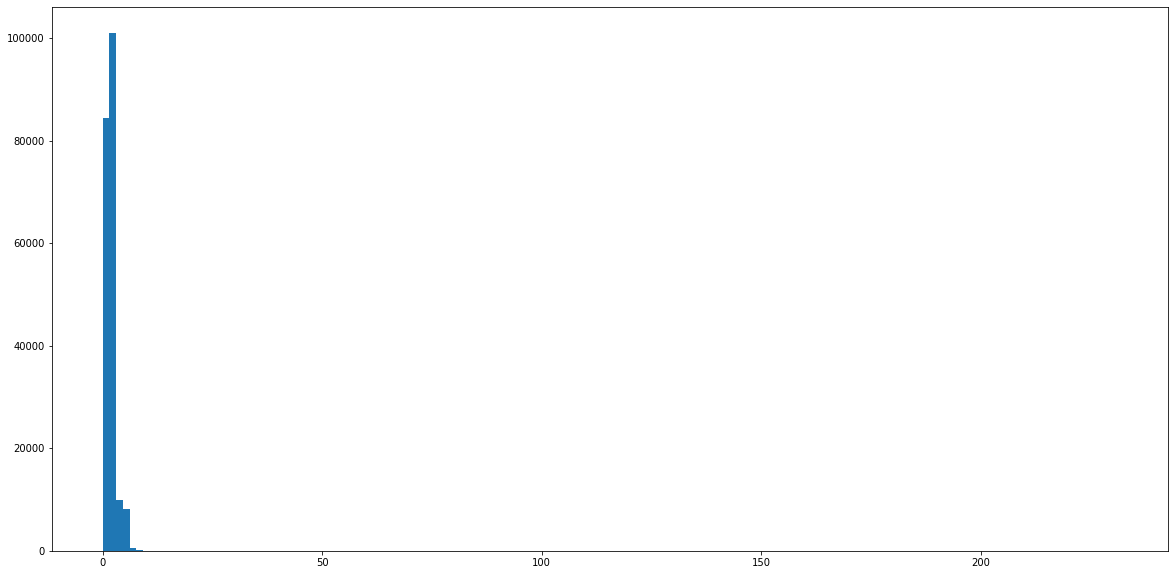

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.hist(comp_gameTime_1["diff_gameTime"],bins=150)


### 2 c) Issue with 4002


#### 2 c.1) two rows when column "foodNeeded" == "FOOD/DRINK"

There are 53122 out of 248377 rows with `foodNeeded` == "FOOD/DRINK". We needed to alter column `foodShot` == "DRINK" to "FOOD/DRINK" if corresponding column `foodNeeded` is "FOOD/DRINK" and in the next row, important to order based on selected keys, all column values except for `logTimestamp` and `gameTime` are the same and `foodShot` == "FOOD". So, we assign `dup_newID`, based on whether all of the column values (including `logTimestamp` and `gameTime`) expect for `foodShot` and `foodNeeded` matched.


In order to reduce error we decided to split the dataframe depending on the techniques we needed to use. 

**Split the rows based on whether for that level we expect  "foodNeeded" == "FOOD/DRINK"**

1. **Not expected levels:** 0 out of 86590 duplicate IDs so no cleaning needed

2. **Expected levels:** 

    If all "foodNeeded" == "FOOD/DRINK" had their corresponding rows and were identified by `dup_newID`, we expected at 53122*2 records but only found  42686 rows out of 161787 with duplicate ids. We found 21343 out 42686 rows of `foodNeeded` == "FOOD/DRINK" had corresponding rows of `foodShot` == "FOOD". For the rest of the rows (31779) either the `logTimestamp` and `gameTime` didn't match or didnt have it's corresponding rows at all (meaning the user only shot one type of food).
   
    - if duplicate ids then we merged the rows
    - if not duplicate ids:
        - some  "foodNeeded" == "FOOD/DRINK" rows where we expect two rows did not have them, so we had to be careful not to alter those
        - other "foodNeeded" == "FOOD/DRINK" rows had corresponding rows, but did not have the same `gameTime` or `logTimestamp`. 
        
        To solve this issue we merged the rows if all column values match except for `gameTime`, `logTimestamp` `foodShot` and `foodNeeded` matched and the difference between those two `gameTime` is less than 7 seconds. If we dont set a threshold for `gameTime` difference the the same game level is played multiple times we could get mismatch. 
        
        We reduced the original dataframe from to 248377 to 195344. 

In [81]:
df_4002_c = grp_game_code_dict[1].copy()
print("number of rows in original 4002 df:", len(df_4002_c))
print("number of rows with FOOD/DRINK original 4002 df:", len(df_4002_c[df_4002_c["foodNeeded"] == "FOOD/DRINK"]))
print("number of unique gameID:", df_4002_c["gameID"].nunique())
df_4002_c.head()

number of rows in original 4002 df: 248377
number of rows with FOOD/DRINK original 4002 df: 53122
number of unique gameID: 4418


,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,foodShot,foodNeeded,attempt,new_gameLevel,gameID,ruleID
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:54,2-0-1,136.0,1,FOOD,FOOD,2,11,56,1
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:12:18,2-0-2,221.0,1,FOOD,FOOD,3,11,115,1
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4002,2018-11-15 09:02:53,2-0-0,159.0,1,DRINK,FOOD,1,11,334,1
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,ce0863b3_21c6d4a0e2f4,4002,2018-11-15 09:04:20,2-0-1,246.0,1,DRINK,DRINK,2,11,392,1
4,ATHF18,16770,rmuve73b7e2rnb10g38ru0hlm0,e1cf8932_2000413e492a,4002,2018-11-20 09:22:06,2-0-1,201.0,1,FOOD,DRINK,2,11,1094,1


In [82]:
#find game levels where we expect foodNeeded == 'FOOD/DRINK'
#two rows that are split of when foodNeeded == 'FOOD/DRINK' have different 'logTimestamp'
#so assume that if the 'logTimestamp' difference is within two seconds for specific 
#userID, gameLevel and alienID then they were split 

#to reduce the number of rows that needs modification split the dataframe into 
#gameLevel where we expect the foodNeeded == 'FOOD/DRINK'


def split_FD_nFD(df):
    df_c = df.copy()
    #get all the possible "gameLevel" with 'foodNeeded'] == 'FOOD/DRINK'
    level_FD = df_c[df_c['foodNeeded'] == 'FOOD/DRINK']['gameLevel'].unique().tolist()
    #get all "gameLevel" with no 'foodNeeded'] == 'FOOD/DRINK'
    level_nFD = set(df_c[df_c['gameLevel'].isin(level_FD) == False]['gameLevel'].unique().tolist()) - set(level_FD)
    
    print("number of levels where FOOD/DRINK is expected:", len(level_FD)) 
    print("number of levels where FOOD/DRINK is not expected:", len(level_nFD))
    print("-"*80)
    
    print("total number of levels:", len(df_c['gameLevel'].unique()))
    df_level_FD = df_c[df_c['gameLevel'].isin(level_FD)]
    print("number of rows where FOOD/DRINK is expected in the gameLevel, is FOOD/DRINK:",
          len(df_level_FD),",", 
          len(df_level_FD[df_level_FD['foodNeeded'] == 'FOOD/DRINK']))
    df_level_nFD = df_c[df_c['gameLevel'].isin(level_nFD)]
    print("number of rows where FOOD/DRINK is not expected in the gameLevel, is FOOD/DRINK:", len(df_level_nFD),",",len(df_level_nFD[df_level_nFD['foodNeeded'] == 'FOOD/DRINK']))
    return df_level_FD, df_level_nFD
    
df_4002_level_FD, df_4002_level_nFD = split_FD_nFD(df_4002_c)   

number of levels where FOOD/DRINK is expected: 77
number of levels where FOOD/DRINK is not expected: 91
--------------------------------------------------------------------------------
total number of levels: 168
number of rows where FOOD/DRINK is expected in the gameLevel, is FOOD/DRINK: 161787 , 53122
number of rows where FOOD/DRINK is not expected in the gameLevel, is FOOD/DRINK: 86590 , 0


In [83]:
def dup_df(df):
    df_c = df.copy()
    z = df['newID'].value_counts() 
    z1 = z.to_dict() #converts to dictionary
    df_c['dup_newID'] = df_c['newID'].map(z1)
    return df_c 

def assign_newID(df):
    if 'csv' in df:
        df = pd.DataFrame(pd.read_csv(df))
    else:
        df = df.copy()
    new_df = df.sort_values(["userID","gsUserID","gameLevel","gameTime","alienID"]).reset_index(drop =True)
    
    new_df['newID'] = new_df.groupby(['accessCode', 'userID', 'sesID', 'gsUserID', 'gameCode', 'gameLevel', 
                                      'alienID', 'gameTime']).ngroup()
    return dup_df(new_df)

#gamelevel doesn't contain "FOOD/DRINK"
test_4002_nFD = assign_newID(df_4002_level_nFD)
print("number of rows when the gameLevel does not contain any \"FOOD/DRINK\":", len(df_4002_level_nFD))
print(len(test_4002_nFD))
print(test_4002_nFD['dup_newID'].value_counts())
print("-"*80)

#gamelevel contains "FOOD/DRINK"
test_4002_FD = assign_newID(df_4002_level_FD)
print("number of rows when the gameLevel contains at least one \"FOOD/DRINK\":", len(df_4002_level_FD))
print(len(test_4002_FD))
print(test_4002_FD['dup_newID'].value_counts())
print("-"*80)
#test_4002_FD[test_4002_FD['dup_newID'] == 2].sort_values(by = ["newID"])

#fortunately the rows that show duplicated "newID" are the only ones with "FOOD/DRINK"
n_dup_ID = len(test_4002_FD[test_4002_FD['dup_newID'] == 2])
n_dup_ID_FD = len(test_4002_FD[(test_4002_FD['foodNeeded']=='FOOD/DRINK')&(test_4002_FD['dup_newID'] == 2)])
n_notdup_ID_FD = len(test_4002_FD[(test_4002_FD['foodNeeded']=='FOOD/DRINK')&(test_4002_FD['dup_newID'] == 1)])

print("number of rows with FOOD/DRINK *2 equals duplicate IDs:",
      n_dup_ID == n_dup_ID_FD*2)
print("number of rows with FOOD/DRINK assigned same id as it's related row:",n_dup_ID_FD)

#unfortunately we are missing some of the duplicate newIDs for "FOOD/DRINK"
print("number of rows with FOOD/DRINK not assigned same id as it's related row if any :", n_notdup_ID_FD)


#just double check none should be NULL
#print(len(test_4002_FD[test_4002_FD['dup_newID'].isnull()]))
#print(len(test_4002_FD[test_4002_FD["newID"].isnull()]))
#print(len(test_4002_nFD[test_4002_nFD['dup_newID'].isnull()]))
#print(len(test_4002_nFD[test_4002_nFD["newID"].isnull()]))


number of rows when the gameLevel does not contain any "FOOD/DRINK": 86590
86590
1    86590
Name: dup_newID, dtype: int64
--------------------------------------------------------------------------------
number of rows when the gameLevel contains at least one "FOOD/DRINK": 161787
161787
1    119101
2     42686
Name: dup_newID, dtype: int64
--------------------------------------------------------------------------------
number of rows with FOOD/DRINK *2 equals duplicate IDs: True
number of rows with FOOD/DRINK assigned same id as it's related row: 21343
number of rows with FOOD/DRINK not assigned same id as it's related row if any : 31779


### split the levels where FOOD/DRINK is expected into two groups based on whether duplicate IDs were generated

- if duplicate ids then we can simply split the dataframe into two whether `foodNeeded` is "FOOD/DRINK" or not
    
    we have a perfect match of 25702 rows
    

- if not duplicate ids then tricky

In [84]:
df_4002_level_FD_w_id = assign_newID(df_4002_level_FD)
print("Number of rows in gameLevel where \"FOOD/DRINK\"  is expected:", len(df_4002_level_FD_w_id),"\n")

#find possible alienIDs `foodNeeded` == "FOOD/DRINK"
#print(len(df_4002_level_FD_w_id[df_4002_level_FD_w_id["foodNeeded"] == "FOOD/DRINK"]["alienID"].unique()))
print("Among duplicate ids")
df_4002_level_FD_2 = df_4002_level_FD_w_id[df_4002_level_FD_w_id['dup_newID'] == 2]
print("Number of rows:", len(df_4002_level_FD_2))

#split the dataframe into two then merge side by side
df_4002_level_FD_2_FD = df_4002_level_FD_2[df_4002_level_FD_2["foodNeeded"] == "FOOD/DRINK"]
print("Number of rows with \"FOOD/DRINK\":", len(df_4002_level_FD_2_FD))
df_4002_level_FD_2_nFD = df_4002_level_FD_2[df_4002_level_FD_2["foodNeeded"] != "FOOD/DRINK"]
print("Number of rows without \"FOOD/DRINK\":",len(df_4002_level_FD_2_FD),"\n")

print("Among no duplicate ids")
df_4002_level_FD_1 = df_4002_level_FD_w_id[df_4002_level_FD_w_id['dup_newID'] == 1]
print("Number of rows:", len(df_4002_level_FD_1))
df_4002_level_FD_1_FD = df_4002_level_FD_1[df_4002_level_FD_1["foodNeeded"] == "FOOD/DRINK"]
print("Number of rows with \"FOOD/DRINK\":",len(df_4002_level_FD_1_FD))
df_4002_level_FD_1_nFD = df_4002_level_FD_1[df_4002_level_FD_1["foodNeeded"] != "FOOD/DRINK"]
print("Number of rows without \"FOOD/DRINK\":",len(df_4002_level_FD_1_nFD))

Number of rows in gameLevel where "FOOD/DRINK"  is expected: 161787 

Among duplicate ids
Number of rows: 42686
Number of rows with "FOOD/DRINK": 21343
Number of rows without "FOOD/DRINK": 21343 

Among no duplicate ids
Number of rows: 119101
Number of rows with "FOOD/DRINK": 31779
Number of rows without "FOOD/DRINK": 87322


In [85]:
def merge_dfs_4002(df1, df2, merge_type = 'outer', show_merge_type=True, same_gameTime = True):
    """
    input: two dataframes
    output: merged dataframe joined based on keys listed in the code
    """
    df1_c= df1.copy()
    df2_c = df2.copy()
    if same_gameTime == True:
        #dont use 'gameID' to merge if accross different file type
        merge_keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', 'gameCode', 
                             'gameTime', 'dup_newID','gameID','attempt']
    else:
        merge_keys = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameLevel', 'alienID', 'gameCode', 
                              'dup_newID','gameID','attempt']
        
    merged_df = pd.merge(df1_c, df2_c, 
                         on=merge_keys, 
                         how=merge_type, 
                         indicator=show_merge_type) 
        
    print("Types of merge:", merged_df["_merge"].unique())
    #  'gameCode','logID', 'jotID', 'gameTime','gameKey','logTimestamp','participantID', 
    #on=["userID", "sesID", "gameLevel", "alienID"],
    if ('gameCode' in df1_c.columns) & ('gameCode' in df2_c.columns): 
        prn_game_code_uniq(df1_c)
        prn_game_code_uniq(df2_c)
    elif 'gameCode' in df1_c.columns: 
        prn_game_code_uniq(df1_c)
    elif 'gameCode' in df2_c.columns: 
        prn_game_code_uniq(df2_c)
        
    #the difference in rows shows the issue 2 a.2) 
    print("Shape of merged :", merged_df.shape)
    dif_df1 = merged_df.shape[0] - df1_c.shape[0]
    dif_df2 = merged_df.shape[0] - df2_c.shape[0]
    print("Difference in rows between merged dataframe and df1 :", dif_df1)
    print("Difference in rows between merged dataframe and df2 :", dif_df2)
    print("-"*100)
    n_both = len(merged_df[merged_df["_merge"] == "both"])
    n_left = len(merged_df[merged_df["_merge"] == "left"])
    n_right = len(merged_df[merged_df["_merge"] == "right"])
    
    #shows issue 2 a.1) i.e. multiple rows for the keys that were selected hence the number of records not matching
    print("We expected the number rows between left and inner as well as right and inner to match and we got\n",
          (len(merged_df)+n_right == df1_c.shape[0]), (len(merged_df)+n_left == df2_c.shape[0])) 
    print("-"*100)
    return merged_df

def merge_foodShot(df):
    df_c = df.copy()
    df_c["new_foodShot"] = np.where(((df_c['foodShot_x'] == "FOOD") & (df_c['foodShot_y'] == "DRINK"))|
                                     ((df_c['foodShot_x'] == "DRINK") & (df_c['foodShot_y'] == "FOOD")), 
                                     "FOOD/DRINK", 
                                     np.where((df_c['foodShot_x'] == "FOOD") & (df_c['foodShot_y'] == "FOOD"),
                                              "FOOD", "DRINK"))
    return df_c


m_df_4002_level_FD_2 = merge_dfs_4002(df_4002_level_FD_2_FD, df_4002_level_FD_2_nFD, merge_type = 'outer', show_merge_type=True)
m_df_4002_level_FD_2.head()

#check if any null in "foodShot_x" and "foodShot_y"
#print(len(m_df_4002_level_FD_2[m_df_4002_level_FD_2['foodShot_x'].isnull()]))
#print(len(m_df_4002_level_FD_2[m_df_4002_level_FD_2['foodShot_y'].isnull()]))

Types of merge: [both]
Categories (1, object): [both]
Shape of game code [4002] : (21343, 17)
Shape of game code [4002] : (21343, 17)
Shape of merged : (21343, 24)
Difference in rows between merged dataframe and df1 : 0
Difference in rows between merged dataframe and df2 : 0
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 True True
----------------------------------------------------------------------------------------------------


,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp_x,gameLevel,gameTime,alienID,foodShot_x,...,ruleID_x,newID_x,dup_newID,logTimestamp_y,foodShot_y,foodNeeded_y,new_gameLevel_y,ruleID_y,newID_y,_merge
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:55,2-0-1,137.0,2,DRINK,...,1,20080,2,2018-11-15 09:10:55,FOOD,FOOD,11,1,20080,both
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:59,2-0-1,141.0,4,FOOD,...,1,20082,2,2018-11-15 09:10:59,DRINK,DRINK,11,1,20082,both
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:07,2-0-1,149.0,8,FOOD,...,1,20087,2,2018-11-15 09:11:07,DRINK,DRINK,11,1,20087,both
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:17,2-0-1,159.0,14,DRINK,...,1,20095,2,2018-11-15 09:11:17,DRINK,FOOD,11,1,20095,both
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:25,2-0-1,167.0,18,FOOD,...,1,20100,2,2018-11-15 09:11:25,DRINK,DRINK,11,1,20100,both


In [86]:
merged_foodshot_dup2_0 = merge_foodShot(m_df_4002_level_FD_2)
merged_foodshot_dup2_0.iloc[:5,5:]   

,logTimestamp_x,gameLevel,gameTime,alienID,foodShot_x,foodNeeded_x,attempt,new_gameLevel_x,gameID,ruleID_x,newID_x,dup_newID,logTimestamp_y,foodShot_y,foodNeeded_y,new_gameLevel_y,ruleID_y,newID_y,_merge,new_foodShot
0,2018-11-15 09:10:55,2-0-1,137.0,2,DRINK,FOOD/DRINK,2,11,56,1,20080,2,2018-11-15 09:10:55,FOOD,FOOD,11,1,20080,both,FOOD/DRINK
1,2018-11-15 09:10:59,2-0-1,141.0,4,FOOD,FOOD/DRINK,2,11,56,1,20082,2,2018-11-15 09:10:59,DRINK,DRINK,11,1,20082,both,FOOD/DRINK
2,2018-11-15 09:11:07,2-0-1,149.0,8,FOOD,FOOD/DRINK,2,11,56,1,20087,2,2018-11-15 09:11:07,DRINK,DRINK,11,1,20087,both,FOOD/DRINK
3,2018-11-15 09:11:17,2-0-1,159.0,14,DRINK,FOOD/DRINK,2,11,56,1,20095,2,2018-11-15 09:11:17,DRINK,FOOD,11,1,20095,both,DRINK
4,2018-11-15 09:11:25,2-0-1,167.0,18,FOOD,FOOD/DRINK,2,11,56,1,20100,2,2018-11-15 09:11:25,DRINK,DRINK,11,1,20100,both,FOOD/DRINK


In [87]:
#if _merge == "both" and the number of rows of merged data is equal to two of the original dataframe then complete match
print(merged_foodshot_dup2_0["_merge"].unique())
print(len(merged_foodshot_dup2_0) == len(df_4002_level_FD_2_FD)==len(df_4002_level_FD_2_nFD))

[both]
Categories (1, object): [both]
True


In [88]:
# looks like when only one food is shot still two rows are created since we assigned dupID such that the 
# only corresponding rows are matched
print(merged_foodshot_dup2_0["new_foodShot"].unique())

['FOOD/DRINK' 'DRINK' 'FOOD']


In [89]:
# we know that gameTime is not same when dup_newID == 1
m_df_4002_level_FD_1 = merge_dfs_4002(df_4002_level_FD_1_FD, df_4002_level_FD_1_nFD, 
                                      merge_type = 'outer', 
                                      show_merge_type=True, 
                                      same_gameTime = False)
m_df_4002_level_FD_1.head()

Types of merge: [both, left_only, right_only]
Categories (3, object): [both, left_only, right_only]
Shape of game code [4002] : (31779, 17)
Shape of game code [4002] : (87322, 17)
Shape of merged : (87409, 25)
Difference in rows between merged dataframe and df1 : 55630
Difference in rows between merged dataframe and df2 : 87
----------------------------------------------------------------------------------------------------
We expected the number rows between left and inner as well as right and inner to match and we got
 False False
----------------------------------------------------------------------------------------------------


,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp_x,gameLevel,gameTime_x,alienID,foodShot_x,...,newID_x,dup_newID,logTimestamp_y,gameTime_y,foodShot_y,foodNeeded_y,new_gameLevel_y,ruleID_y,newID_y,_merge
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:04,2-0-1,146.0,7.0,FOOD,...,20085.0,1,2018-11-15 09:11:06,148.0,FOOD,DRINK,11.0,1,20086.0,both
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:13,2-0-1,155.0,12.0,FOOD,...,20091.0,1,2018-11-15 09:11:13,156.0,FOOD,DRINK,11.0,1,20092.0,both
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:15,2-0-1,157.0,13.0,FOOD,...,20093.0,1,2018-11-15 09:11:16,158.0,FOOD,DRINK,11.0,1,20094.0,both
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:22,2-0-1,164.0,17.0,FOOD,...,20098.0,1,2018-11-15 09:11:24,166.0,FOOD,DRINK,11.0,1,20099.0,both
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:42,2-0-1,184.0,28.0,FOOD,...,20110.0,1,2018-11-15 09:11:43,185.0,DRINK,DRINK,11.0,1,20111.0,both


In [90]:
#Since we are not using gameTime as a key if the "_merge" != both then we expect no match found for those rows
m_df_4002_level_FD_1_both = m_df_4002_level_FD_1[m_df_4002_level_FD_1["_merge"] == "both"]
print("number of rows where \"FOOD/DRINK\" might have corresponding rows:", len(m_df_4002_level_FD_1_both))
m_df_4002_level_FD_1_left = m_df_4002_level_FD_1[m_df_4002_level_FD_1["_merge"] == "left_only"]
print("number of rows where \"FOOD/DRINK\" doesn't have corresponding rows:", len(m_df_4002_level_FD_1_left))
m_df_4002_level_FD_1_right = m_df_4002_level_FD_1[m_df_4002_level_FD_1["_merge"] == "right_only"]
print("number of rows where \"FOOD\" or \"DRINK\" doesn't have corresponding rows:", len(m_df_4002_level_FD_1_right))

number of rows where "FOOD/DRINK" might have corresponding rows: 31692
number of rows where "FOOD/DRINK" doesn't have corresponding rows: 87
number of rows where "FOOD" or "DRINK" doesn't have corresponding rows: 55630


In [91]:
# we can go ahead and concatenate left_only and right_only as it was before
def concat_lr(merged_df, replace_col_xy = True):
    merged_df_c = merged_df.copy()
    left_df = merged_df_c.loc[merged_df_c['_merge']=='left_only'].dropna(axis=1).drop(columns = '_merge')
    if replace_col_xy == True:
        left_df.columns = left_df.columns.str.replace("_x", "")
    #print(len(merged_df.loc[merged_df['_merge']=='left_only'])==len(left_df))

    right_df = merged_df_c.loc[merged_df_c['_merge']=='right_only'].dropna(axis=1).drop(columns = '_merge')
    if replace_col_xy == True:
        right_df.columns = right_df.columns.str.replace("_y", "")
    #print(len(merged_df.loc[merged_df['_merge']=='right_only'])==len(right_df))
    final_merged_df = pd.concat([left_df,right_df ])
    print("final left and right dataframe concatenated should be True:", len(final_merged_df) == len(left_df)+len(right_df))
    return final_merged_df

m_df_4002_level_FD_1_lr = concat_lr(m_df_4002_level_FD_1)
m_df_4002_level_FD_1_lr.head()

final left and right dataframe concatenated should be True: True


,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp,gameLevel,gameTime,alienID,foodShot,foodNeeded,attempt,new_gameLevel,gameID,ruleID,newID,dup_newID
899,ATHF18,16785,5vobmem5a5itpkdthm8qe5tt12,b5391b8e_f5cbfb91505a,4002,2018-11-15 09:17:24,3-1-0,1054.0,3.0,FOOD,FOOD/DRINK,1,17.0,11622,1,23945.0,1
1198,ATHF18,16791,3h8ta54kengkbuag795oujpo57,de0c000e_e2d248c33ee4,4002,2018-11-20 09:22:04,2-1-3,317.0,2.0,DRINK,FOOD/DRINK,4,12.0,14567,1,24981.0,1
1211,ATHF18,16791,3h8ta54kengkbuag795oujpo57,de0c000e_e2d248c33ee4,4002,2018-11-20 09:23:07,2-1-3,380.0,34.0,DRINK,FOOD/DRINK,4,12.0,14567,1,25025.0,1
2781,ATHF18,16821,ieknoq49olq10juirtdt83tma1,7785dda0_5f832dab7c3c,4002,2018-11-20 11:21:06,2-0-0,47.0,6.0,DRINK,FOOD/DRINK,1,11.0,33225,1,33043.0,1
2882,ATHF18,16821,2in894db86fi351s3mcjen6a47,8f43e34b_18eed09d0823,4002,2018-10-23 11:37:42,0-4-1,631.0,11.0,FOOD,FOOD/DRINK,2,5.0,34053,2,32795.0,1


In [92]:
# We have selected merge keys such that only the "_merge" == "both" could have related pair of rows, 
# and we will check the relation by taking difference between two gameTime

comp_gameTime_4002 = comp_gameTime(m_df_4002_level_FD_1_both)
comp_gameTime_4002.sort_values("diff_gameTime", ascending = False).head()

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp_x,gameLevel,gameTime_x,alienID,foodShot_x,...,dup_newID,logTimestamp_y,gameTime_y,foodShot_y,foodNeeded_y,new_gameLevel_y,ruleID_y,newID_y,_merge,diff_gameTime
3437,ATHF18,16830,em6l2de3l07kcvdm4crultctf4,42ff5f0a_78782f1474fe,4002,2018-11-20 11:24:28,2-1-3,767.0,29.0,DRINK,...,1,2018-11-20 11:24:53,792.0,DRINK,FOOD,12.0,1,35704.0,both,25
9295,ATM1F18,16927,9hkb8oseqi8ck3shkmpl0qn6v4,72bed7cb_656d664b1c52,4002,2018-11-27 09:01:04,2-2-0,652.0,40.0,FOOD,...,1,2018-11-27 09:01:22,670.0,FOOD,DRINK,13.0,2,41690.0,both,18
1395,ATHF18,16800,qkfmccrdu9lfvr1lvfuj9jv4i3,7bf5558d_8cdddb1fb7fa,4002,2018-11-20 09:49:29,2-0-1,182.0,27.0,FOOD,...,1,2018-11-20 09:49:34,188.0,FOOD,DRINK,11.0,1,26627.0,both,6
3692,ATHF18,16833,o5a36s9l4ishqjts8gsh6q68i6,e0c04ac1_27497d795153,4002,2018-11-13 11:48:40,2-4-0,749.0,20.0,DRINK,...,1,2018-11-13 11:48:46,755.0,FOOD,FOOD,15.0,1,36163.0,both,6
2780,ATHF18,16821,ieknoq49olq10juirtdt83tma1,7785dda0_5f832dab7c3c,4002,2018-11-20 11:21:00,2-0-0,41.0,5.0,FOOD,...,1,2018-11-20 11:21:05,47.0,DRINK,DRINK,11.0,1,33042.0,both,6


In [93]:
comp_gameTime_4002["diff_gameTime"].describe()

count    31692.000000
mean         1.057365
std          0.316557
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         25.000000
Name: diff_gameTime, dtype: float64

In [94]:
print(np.array(sorted(comp_gameTime_4002["diff_gameTime"].unique())))

[ 1  2  3  4  5  6 18 25]


(array([3.0138e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.3900e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.2400e+02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.3000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

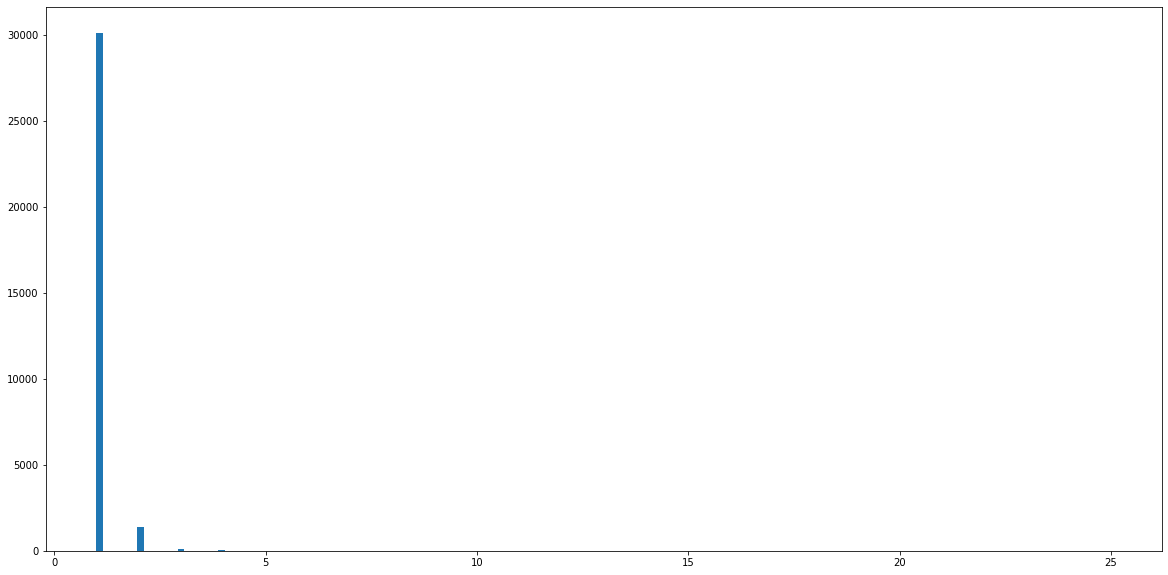

In [95]:
plt.figure(figsize=(20,10))
plt.hist(comp_gameTime_4002["diff_gameTime"],bins=150)

In [96]:
m_df_4002_level_FD_1_both_merge = comp_gameTime_4002[comp_gameTime_4002["diff_gameTime"] <=6]
m_df_4002_level_FD_1_both_not_merge = comp_gameTime_4002[comp_gameTime_4002["diff_gameTime"] > 6]
print(m_df_4002_level_FD_1_both_merge["diff_gameTime"].describe())
print(m_df_4002_level_FD_1_both_not_merge["diff_gameTime"].describe())

count    31690.000000
mean         1.056074
std          0.270305
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: diff_gameTime, dtype: float64
count     2.000000
mean     21.500000
std       4.949747
min      18.000000
25%      19.750000
50%      21.500000
75%      23.250000
max      25.000000
Name: diff_gameTime, dtype: float64


In [97]:
merged_foodshot_dup2_1 = merge_foodShot(m_df_4002_level_FD_1_both_merge)
merged_foodshot_dup2_1.iloc[:5,5:]  

,logTimestamp_x,gameLevel,gameTime_x,alienID,foodShot_x,foodNeeded_x,attempt,new_gameLevel_x,gameID,ruleID_x,...,logTimestamp_y,gameTime_y,foodShot_y,foodNeeded_y,new_gameLevel_y,ruleID_y,newID_y,_merge,diff_gameTime,new_foodShot
0,2018-11-15 09:11:04,2-0-1,146.0,7.0,FOOD,FOOD/DRINK,2,11.0,56,1,...,2018-11-15 09:11:06,148.0,FOOD,DRINK,11.0,1,20086.0,both,2,FOOD
1,2018-11-15 09:11:13,2-0-1,155.0,12.0,FOOD,FOOD/DRINK,2,11.0,56,1,...,2018-11-15 09:11:13,156.0,FOOD,DRINK,11.0,1,20092.0,both,1,FOOD
2,2018-11-15 09:11:15,2-0-1,157.0,13.0,FOOD,FOOD/DRINK,2,11.0,56,1,...,2018-11-15 09:11:16,158.0,FOOD,DRINK,11.0,1,20094.0,both,1,FOOD
3,2018-11-15 09:11:22,2-0-1,164.0,17.0,FOOD,FOOD/DRINK,2,11.0,56,1,...,2018-11-15 09:11:24,166.0,FOOD,DRINK,11.0,1,20099.0,both,2,FOOD
4,2018-11-15 09:11:42,2-0-1,184.0,28.0,FOOD,FOOD/DRINK,2,11.0,56,1,...,2018-11-15 09:11:43,185.0,DRINK,DRINK,11.0,1,20111.0,both,1,FOOD/DRINK


In [98]:
merged_foodshot_dup2_1=merged_foodshot_dup2_1.drop(columns = ["diff_gameTime", "gameTime_y"]).rename(columns = {"gameTime_x" : "gameTime"})
print((merged_foodshot_dup2_0.columns.values == merged_foodshot_dup2_1.columns.values).all())

True


In [99]:
merged_foodshot_dup2 = pd.concat([merged_foodshot_dup2_0, merged_foodshot_dup2_1])
merged_foodshot_dup2.head()

,accessCode,userID,sesID,gsUserID,gameCode,logTimestamp_x,gameLevel,gameTime,alienID,foodShot_x,...,newID_x,dup_newID,logTimestamp_y,foodShot_y,foodNeeded_y,new_gameLevel_y,ruleID_y,newID_y,_merge,new_foodShot
0,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:55,2-0-1,137.0,2,DRINK,...,20080.0,2,2018-11-15 09:10:55,FOOD,FOOD,11.0,1,20080.0,both,FOOD/DRINK
1,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:10:59,2-0-1,141.0,4,FOOD,...,20082.0,2,2018-11-15 09:10:59,DRINK,DRINK,11.0,1,20082.0,both,FOOD/DRINK
2,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:07,2-0-1,149.0,8,FOOD,...,20087.0,2,2018-11-15 09:11:07,DRINK,DRINK,11.0,1,20087.0,both,FOOD/DRINK
3,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:17,2-0-1,159.0,14,DRINK,...,20095.0,2,2018-11-15 09:11:17,DRINK,FOOD,11.0,1,20095.0,both,DRINK
4,ATHF18,16770,mpb2ggm2ul0fshbuh2uppd56b4,450f79a9_864d064678c8,4002,2018-11-15 09:11:25,2-0-1,167.0,18,FOOD,...,20100.0,2,2018-11-15 09:11:25,DRINK,DRINK,11.0,1,20100.0,both,FOOD/DRINK


In [100]:
print(merged_foodshot_dup2.columns.values)
print(m_df_4002_level_FD_1_lr.columns.values)

['accessCode' 'userID' 'sesID' 'gsUserID' 'gameCode' 'logTimestamp_x'
 'gameLevel' 'gameTime' 'alienID' 'foodShot_x' 'foodNeeded_x' 'attempt'
 'new_gameLevel_x' 'gameID' 'ruleID_x' 'newID_x' 'dup_newID'
 'logTimestamp_y' 'foodShot_y' 'foodNeeded_y' 'new_gameLevel_y' 'ruleID_y'
 'newID_y' '_merge' 'new_foodShot']
['accessCode' 'userID' 'sesID' 'gsUserID' 'gameCode' 'logTimestamp'
 'gameLevel' 'gameTime' 'alienID' 'foodShot' 'foodNeeded' 'attempt'
 'new_gameLevel' 'gameID' 'ruleID' 'newID' 'dup_newID']


In [101]:
print((merged_foodshot_dup2["ruleID_x"]==merged_foodshot_dup2["ruleID_y"]).all())
print((merged_foodshot_dup2["new_gameLevel_x"]==merged_foodshot_dup2["new_gameLevel_y"]).all())

True
True


In [102]:
clean_merged_foodshot_dup2 = merged_foodshot_dup2.copy()
drop_cols = ['foodShot_x', 'newID_x', 'newID_y', 'logTimestamp_y', 'foodShot_y', 'foodNeeded_y',
             'new_gameLevel_y', 'ruleID_y', '_merge', 'dup_newID']
clean_merged_foodshot_dup2 = clean_merged_foodshot_dup2.drop(columns = drop_cols).rename(columns={'foodNeeded_x': 'foodNeeded', 'new_foodShot' : 'foodShot','ruleID_x' : 'ruleID', 'new_gameLevel_x': 'new_gameLevel','logTimestamp_x':'logTimestamp'})
print(clean_merged_foodshot_dup2.columns.values)

['accessCode' 'userID' 'sesID' 'gsUserID' 'gameCode' 'logTimestamp'
 'gameLevel' 'gameTime' 'alienID' 'foodNeeded' 'attempt' 'new_gameLevel'
 'gameID' 'ruleID' 'foodShot']


In [103]:
#dont need newID, dup_newID because created to check duplicates
clean_m_df_4002_level_FD_1_lr=m_df_4002_level_FD_1_lr.copy()
clean_m_df_4002_level_FD_1_lr=clean_m_df_4002_level_FD_1_lr.drop(columns=['newID', 'dup_newID'])
print(clean_m_df_4002_level_FD_1_lr.columns.values)

['accessCode' 'userID' 'sesID' 'gsUserID' 'gameCode' 'logTimestamp'
 'gameLevel' 'gameTime' 'alienID' 'foodShot' 'foodNeeded' 'attempt'
 'new_gameLevel' 'gameID' 'ruleID']


In [104]:
clean_df_4002_1 = pd.concat([clean_m_df_4002_level_FD_1_lr, clean_merged_foodshot_dup2])
clean_df_4002_1.shape

(108750, 15)

In [105]:
left_cols = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameCode', 'logTimestamp_x', 'gameLevel', 
             'gameTime_x', 'alienID', 'foodShot_x', 'foodNeeded_x', 'attempt', 'new_gameLevel_x', 'gameID',
             'ruleID_x']

right_cols = ['accessCode', 'userID', 'sesID', 'gsUserID', 'gameCode','logTimestamp_y', 'gameLevel', 
              'gameTime_y', 'alienID',  'foodShot_y', 'foodNeeded_y', 'attempt', 'new_gameLevel_y', 'gameID', 
              'ruleID_y']

not_merge_4002_left = m_df_4002_level_FD_1_both_not_merge[left_cols]
not_merge_4002_left = not_merge_4002_left.rename(
    columns = {'logTimestamp_x':'logTimestamp','gameTime_x' : 'gameTime', 'foodShot_x':'foodShot', 
               'foodNeeded_x':'foodNeeded', 'new_gameLevel_x':'new_gameLevel', 'ruleID_x':'ruleID'})
print(not_merge_4002_left.shape)
not_merge_4002_right = m_df_4002_level_FD_1_both_not_merge[right_cols]
not_merge_4002_right = not_merge_4002_right.rename(
    columns = {'logTimestamp_y':'logTimestamp','gameTime_y' : 'gameTime', 'foodShot_y':'foodShot', 
               'foodNeeded_y':'foodNeeded', 'new_gameLevel_y':'new_gameLevel', 'ruleID_y':'ruleID'})
print(not_merge_4002_right.shape)


(2, 15)
(2, 15)


In [106]:
clean_df_4002_2 = pd.concat([not_merge_4002_left, not_merge_4002_right])
print(clean_df_4002_2.shape)

(4, 15)


In [107]:
clean_df_4002_exp = pd.concat([clean_df_4002_1,clean_df_4002_2])
print(clean_df_4002_exp.shape)
clean_df_4002_nexp = df_4002_level_nFD.copy()
print(clean_df_4002_nexp.shape)


(108754, 15)
(86590, 15)


In [108]:
final_df_4002= pd.concat([clean_df_4002_exp,clean_df_4002_nexp])
print(final_df_4002.shape)

(195344, 15)
